<br></br>
<br></br>
<font size="10">
    厄瓜多尔商店销量预测
</font>
<br></br>
<br></br>
<font size="3">
    姓名：李舒沛
</font>
<br></br>

<font size="3">
    学号：18307100146
</font>

In [1]:
# 导入需要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os
import itertools
from tqdm import tqdm

# 3.1.1 ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# 3.1.2 Auto ARIMA
from pmdarima.arima import auto_arima

# 3.2 LSTM
import tensorflow as tf

# 3.3 Hybrid model
from sklearn import linear_model # linear, ridge, lasso
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

pd.set_option("display.max_rows", 6)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.sans-serif"] = [u"SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 设置路径
base_path = r"./Dataset/" # kaggle r"../input/store-sales-time-series-forecasting/"
re_path = r"./Results/"

# 定义常用函数
def convert_datetime(dt):
    """
    类型转换：datetime -> object
    """
    return datetime.datetime.strftime(dt, "%Y-%m-%d")

def date_col(df):
    """
    日期转换
    """
    df["date"] = pd.to_datetime(df["date"])
    return df

def proper_np(X):
    """
    numpy: object->float32
    """
    X = np.asarray(X).astype(np.float32)
    return X

# 数据集介绍

<p style="line-height:2">
    本报告使用的数据来自 kaggle 竞赛 "Store Sales - Time Series Forecasting"，网址为：<a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview">https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview</a> 。竞赛的目标是预测位于厄瓜多尔的 Favorita 连锁商店销售额，评估标准是 RMSE。原数据集包括七个 csv 文件：train.csv、test.csv、sample_submission.csv、stores.csv、oil.csv、holidays_events.csv、transactions.csv。下面对这些数据进行逐一介绍。
</p>

<p style="line-height:2">
    <b>注：./Results 下的 csv 文件为提交到 kaggle 的预测结果。</b>
</p>

In [2]:
# 读取数据
holidays = pd.read_csv(base_path + "holidays_events.csv")
oil = pd.read_csv(base_path + "oil.csv")
stores = pd.read_csv(base_path + "stores.csv")
train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")
transactions = pd.read_csv(base_path + "transactions.csv")
sample = pd.read_csv(base_path + "sample_submission.csv")

## Train

<p style="line-height:2">
    训练集为商店销售记录的时间序列数据，时间跨度为 2013 年 1 月 1 日至 2017 年 8 月 15 日，共有 3000888 条记录。数据表包括六个字段: id、date、store_nbr、family、sales、onpromotion，字段含义如下表所示。
</p>

|字段|含义|
|:-|:-|
|id|记录编号|
|date|日期|
|store_nbr|商店编号|
|family|商品类型|
|sales|销售额|
|onpromotion|该商店在该日期进行打折的商品种类数目|

In [3]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
...,...,...,...,...,...,...
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


<p style="line-height:2">
    可以看到，每一条记录对应的是给定日期某一家商店的某一个商品种类销售情况。
</p>

## Test

<p style="line-height:2">
    与训练集相比，测试集不包括作为预测目标的 sales 字段，其他字段含义均保持一致。测试集数据的时间跨度为 2017 年 8 月 16 日至 2017 年 8 月 31 日，共有 28512 条记录。
</p>

In [4]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
...,...,...,...,...,...
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


## Sample Submission

<p style="line-height:2">
    kaggle 竞赛官网给出了提交的预测结果示例，需要包括 id 和 sales 两列，对应测试集的 28512 条记录。在之后的分析中将忽略该数据表。
</p>

In [5]:
sample

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
...,...,...
28509,3029397,0.0
28510,3029398,0.0
28511,3029399,0.0


## Stores

<p style="line-height:2">
    该表为 54 家超市的相关信息，包括 5 个字段：store_nbr、city、state、type、cluster。字段含义如下表所示。
</p>

|字段|含义|
|:-|:-|
|store_nbr|商店编号|
|city|商店所在城市|
|state|商店所在州|
|type|商店类型|
|cluster|商店聚类，相似的商店为一类|

In [6]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
...,...,...,...,...,...
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


## Oil

<p style="line-height:2">
    该表为厄瓜多尔的每日石油价格，时间跨度覆盖训练集和测试集。kaggle 竞赛官网提示：厄瓜多尔是一个依赖石油的国家，石油价格的涨跌对其经济状况有很大影响。数据表包括 date、dcoilwtico 两个字段，共有 1218 条记录。
</p>

|字段|含义|
|:-|:-|
|date|日期|
|dcoilwtico|该日期石油价格|

In [7]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
...,...,...
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


## Holidays Events

<p style="line-height:2">
    2013 - 2017 年厄瓜多尔的节假日汇总表，共包括 350 条记录，6 个字段：date、type、locale、locale_name、description、transferred。下表总结了各个字段的含义。
</p>

|字段|含义|
|:-|:-|
|date|日期|
|type|节假日类型|
|locale|节假日规模|
|locale_name|节假日地点|
|description|节假日描述|
|transferred|日期是否被调整|

<p style="line-height:2">
    kaggle 官网提示：transferred 为 True 的日期更像是工作日，而非节假日。
</p>

In [8]:
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
...,...,...,...,...,...,...
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


## Transactions

<p style="line-height:2">
    该数据表为 <b>覆盖训练集时间段</b> 的商店总交易数记录，共有 83488 条记录，3 个字段：date、store_nbr、transactions。字段含义如下表所示。
</p>

|字段|含义|
|:-|:-|
|date|日期|
|store_nbr|商店编号|
|transactions|该日期给定商店的总交易数|

In [9]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
...,...,...,...
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


# 数据探索性分析

<p style="line-height:2">
    本节将使用 Numpy、Pandas、Matplotlib、Seaborn 对数据进行探索性分析。
</p>

## 数据缺失情况

<p style="line-height:2">
    首先，对六张数据表的缺失值进行统计。
</p>

In [10]:
# 缺失值统计
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")
print("stores:\n" + str(stores.isna().sum()) + "\n")
print("oil:\n" + str(oil.isna().sum()) + "\n")
print("holidays:\n" + str(holidays.isna().sum()) + "\n")
print("transactions:\n" + str(transactions.isna().sum()) + "\n")

train:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

test:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

stores:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

oil:
date           0
dcoilwtico    43
dtype: int64

holidays:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

transactions:
date            0
store_nbr       0
transactions    0
dtype: int64



<p style="line-height:2">
    可以看到，除了 oil 表的 dcoilwtico 列有 43 个缺失值，其他表均无数据缺失。接下来通过插值法对 oil 表进行数据填充。
</p>

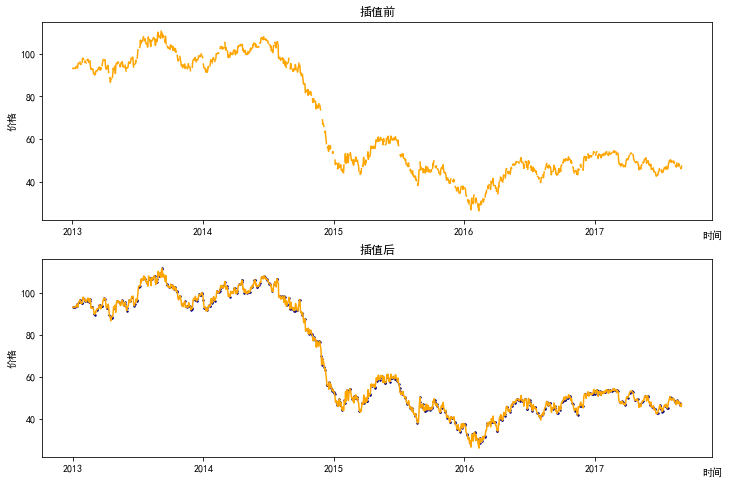

In [3]:
date_full = pd.DataFrame(pd.date_range(start="2013-01-01", end="2017-08-31"), columns=["date"])
date_full["date"] = date_full["date"].apply(convert_datetime)
oil = pd.merge(date_full, oil, on="date", how="left")

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(pd.to_datetime(oil["date"]), oil["dcoilwtico"], "orange")
axs[0].set_xlabel("时间")
axs[0].set_ylabel("价格")
axs[0].xaxis.set_label_coords(1, -0.05)
axs[0].title.set_text("插值前")

oil_nan = oil[oil["dcoilwtico"].isna()]
oil = oil.interpolate(method="polynomial", order=2)
oil[oil.columns[1]] = oil[oil.columns[1]].fillna(method="bfill")
oil_nan = pd.merge(oil_nan, oil, on="date", how="left")
axs[1].plot(pd.to_datetime(oil["date"]), oil["dcoilwtico"], color="orange")
axs[1].scatter(pd.to_datetime(oil_nan["date"]), oil_nan["dcoilwtico_y"], color="navy", s=2)
axs[1].set_xlabel("时间")
axs[1].set_ylabel("价格")
axs[1].xaxis.set_label_coords(1, -0.05)
axs[1].title.set_text("插值后")
plt.show()

<p style="line-height:2">
    检查插值后的 oil 表。
</p>

In [12]:
print("oil:\n" + str(oil.isna().sum()) + "\n")

oil:
date          0
dcoilwtico    0
dtype: int64



<p style="line-height:2">
    数据缺失值处理完毕。
</p>

## 销售额

<p style="line-height:2">
    本小节探索销售额与其他变量之间的关系，销售额使用训练集的 sales 列。在此之前，先对数据表的日期列进行类型转换。
</p>

In [4]:
# 日期列类型转换
train = date_col(train)
test = date_col(test)
oil = date_col(oil)
holidays = date_col(holidays)
transactions = date_col(transactions)

<p style="line-height:2">
    训练集销售额的描述性统计。
</p>

### 商品类型

<strong> 描述性统计 </strong>

<p style="line-height:2">
    根据商品类型，对销售额进行聚类和描述性统计。
</p>

In [5]:
train_family = train["family"].unique()
print("商品类型有：")
for item in train_family:
    print(item, end=", ")
print(f"共 {train_family.shape[0]} 种。")

商品类型有：
AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOOKS, BREAD/BAKERY, CELEBRATION, CLEANING, DAIRY, DELI, EGGS, FROZEN FOODS, GROCERY I, GROCERY II, HARDWARE, HOME AND KITCHEN I, HOME AND KITCHEN II, HOME APPLIANCES, HOME CARE, LADIESWEAR, LAWN AND GARDEN, LINGERIE, LIQUOR,WINE,BEER, MAGAZINES, MEATS, PERSONAL CARE, PET SUPPLIES, PLAYERS AND ELECTRONICS, POULTRY, PREPARED FOODS, PRODUCE, SCHOOL AND OFFICE SUPPLIES, SEAFOOD, 共 33 种。


In [15]:
train.groupby(by="family")["sales"].describe()

,count,mean,std,min,25%,50%,75%,max
family,,,,,,,,
AUTOMOTIVE,90936.0,6.101236,6.191691,0.0,2.0,5.0000,8.00000,255.000
BABY CARE,90936.0,0.110528,0.681064,0.0,0.0,0.0000,0.00000,116.000
BEAUTY,90936.0,3.715723,4.794668,0.0,0.0,2.0000,5.00000,136.000
...,...,...,...,...,...,...,...,...
PRODUCE,90936.0,1349.352123,2186.481332,0.0,0.0,398.2905,1798.89400,17850.615
SCHOOL AND OFFICE SUPPLIES,90936.0,2.961599,21.745937,0.0,0.0,0.0000,1.00000,1332.000
SEAFOOD,90936.0,22.163190,32.627628,0.0,1.0,8.0000,28.28025,274.440


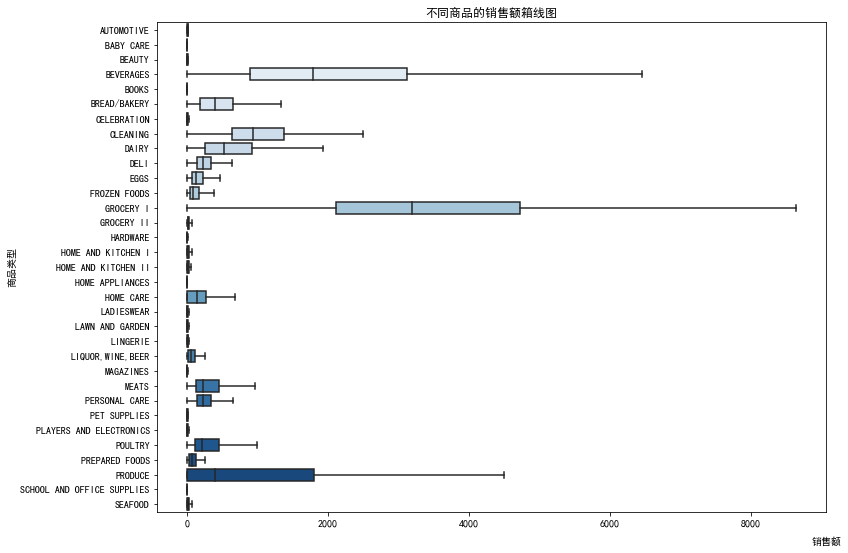

In [16]:
fig, ax = plt.subplots(figsize=(12, 9))
fig = sns.boxplot(x="sales", y="family", data=train, showfliers=False, palette="Blues")
ax.set(xlabel="销售额", ylabel="商品类型", title="不同商品的销售额箱线图")
ax.xaxis.set_label_coords(1, -0.05)
plt.show()

<p style="line-height:2">
    可以看到，不同类型的商品销售额差异很大。销售额的前三名分别是：GROCERY I、BEVERAGES、PRODUCE。
</p>

<strong> 销售额变化趋势 </strong>

<p style="line-height:2">
    那么，不同类型的商品销售额变化趋势会有明显差异吗？以上述销售额前三名的商品类型为例，进行数据可视化。
</p>

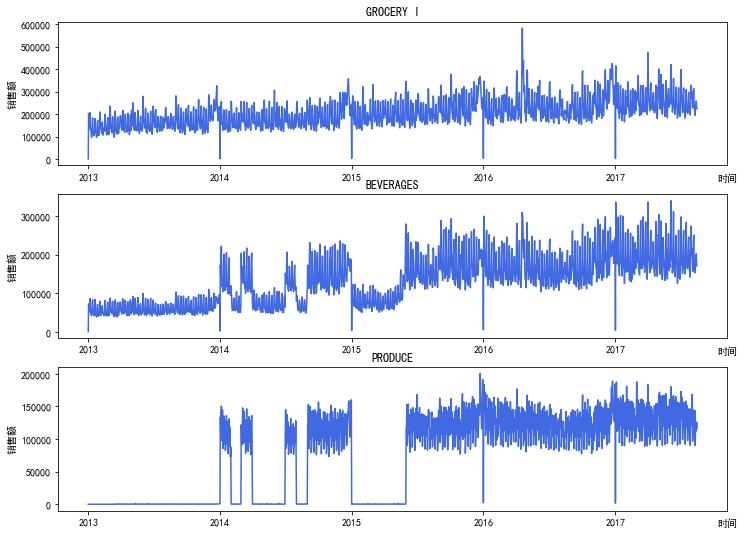

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9))
sns.lineplot(ax=axs[0], data=train[train["family"] == "GROCERY I"].groupby(by=["date"]).sum(), 
             x="date", y="sales", color="royalblue")
axs[0].set(xlabel="时间", ylabel="销售额", title="GROCERY I")
axs[0].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[1], data=train[train["family"] == "BEVERAGES"].groupby(by=["date"]).sum(), 
             x="date", y="sales", color="royalblue")
axs[1].set(xlabel="时间", ylabel="销售额", title="BEVERAGES")
axs[1].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[2], data=train[train["family"] == "PRODUCE"].groupby(by=["date"]).sum(), 
             x="date", y="sales", color="royalblue")
axs[2].set(xlabel="时间", ylabel="销售额", title="PRODUCE")
axs[2].xaxis.set_label_coords(1, -0.05)

<p style="line-height:2">
    不同类型商品的销售额变化趋势差异显著，后续建模时应考虑这一因素。
</p>

### 商店

<strong> 描述性统计 </strong>

<p style="line-height:2">
    不同商店销售额的聚类及描述性统计如下。
</p>

In [6]:
train_store_nbr = train["store_nbr"].unique()
print("商店有：")
for item in train_store_nbr:
    print(item, end=", ")
print(f"共 {train_store_nbr.shape[0]} 家。")

商店有：
1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 6, 7, 8, 9, 共 54 家。


In [23]:
# 后面删除未营业记录后再运行一次
train_store = pd.merge(train, stores, on="store_nbr", how="left")
train_store.groupby(by="store_nbr")["sales"].describe()

,count,mean,std,min,25%,50%,75%,max
store_nbr,,,,,,,,
1,55572.0,254.534889,596.827146,0.0,1.0,19.000,166.00000,9065.0
2,55572.0,387.918172,1079.560490,0.0,2.0,23.217,291.00000,124717.0
3,55572.0,908.405495,2146.185033,0.0,4.0,64.000,586.00000,21858.0
...,...,...,...,...,...,...,...,...
52,3894.0,692.390789,1559.912876,0.0,9.0,58.500,436.12200,10462.0
53,38676.0,290.003291,701.750090,0.0,2.0,14.000,205.41325,8443.0
54,55572.0,198.975799,582.223307,0.0,0.0,6.000,98.00000,17614.0


<strong> 销售额变化趋势 </strong>

<p style="line-height:2">
    不同商店销售额的变化趋势会有显著差异吗？以编号为 18、19、20 的三家商店为例，进行数据可视化。
</p>

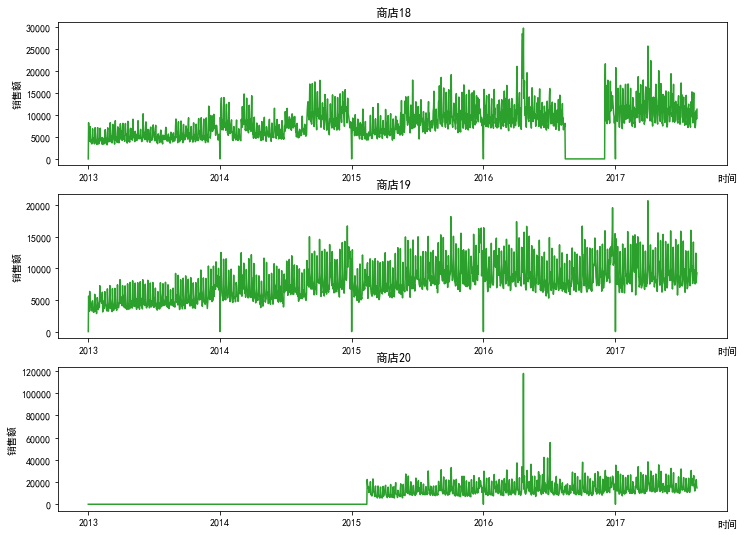

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9))
sns.lineplot(ax=axs[0], data=train[train["store_nbr"] == 18].groupby(by=["date"]).sum(), 
             x="date", y="sales", color="tab:green")
axs[0].set(xlabel="时间", ylabel="销售额", title="商店18")
axs[0].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[1], data=train[train["store_nbr"] == 19].groupby(by=["date"]).sum(), 
             x="date", y="sales", color="tab:green")
axs[1].set(xlabel="时间", ylabel="销售额", title="商店19")
axs[1].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[2], data=train[train["store_nbr"] == 20].groupby(by=["date"]).sum(), 
             x="date", y="sales", color="tab:green")
axs[2].set(xlabel="时间", ylabel="销售额", title="商店20")
axs[2].xaxis.set_label_coords(1, -0.05)

<p style="line-height:2">
    从上图可以看出，不同商店的销售额变化模式有很大差异。之后进行建模时应考虑这一因素。
</p>

<p style="line-height:2">
    此外，商店的销售额记录可能在一段时间内为 0，分为三种情况：
</p>

<ol style="line-height:2">
  <li>商店销售额记录是连续的，不存在销售额为 0 的时间段。</li>
  <li>商店销售额开始为 0，从某个时间节点后才有连续的记录。推测是在此时间节点之前，商店没有开业。</li>
  <li>商店销售额开始为连续的，之后的某几个时间段内销售额变为 0。推测是这几个时间段由于店铺升级、技术设备维护等原因，商店没有营业。</li>
</ol>

<p style="line-height:2">
    在此特别留意上述情况 2。之后进行建模时，应将商店未开业的销售额记录从训练集中删除。下面先找出各家商店的开业时间，再将未开业时间段的销售额记录删除。
</p>

<strong> 删除未开业时间段 </strong>

In [7]:
# 商店开业时间
opening_time = []

for i in range(1, 55):
    one_store = train[train["store_nbr"] == i].groupby(by=["date"]).sum()["sales"].reset_index()
    one_time = one_store.loc[one_store["sales"] > 0, "date"].min()
    if one_time.date() == datetime.date(2013, 1, 2):
        opening_time.append(datetime.date(2013, 1, 1))
    else:
        opening_time.append(one_time.date())

opening_time_df = pd.DataFrame({"store_nbr": [i for i in range(1, 55)],
                                "opening": opening_time})
opening_time_df["opening"] = pd.to_datetime(opening_time_df["opening"])
opening_time_df

,store_nbr,opening
0,1,2013-01-01
1,2,2013-01-01
2,3,2013-01-01
...,...,...
51,52,2017-04-20
52,53,2014-05-29
53,54,2013-01-01


In [8]:
# 删除未开业时间段的记录
for i in range(54):
    one_time = opening_time_df.iloc[i, 1]
    one_store = opening_time_df.iloc[i, 0]
    train = train.drop(train[(train["store_nbr"] == one_store) & (train["date"] < one_time)].index)

train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
...,...,...,...,...,...,...
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


<p style="line-height:2">
    删除未开业时间段的观测后，训练集剩余 2780316 条记录。
</p>

<strong> 地理位置 </strong>

<p style="line-height:2">
    商店的地理位置对商店的销售额有影响吗？下面分别从州、市两个行政单位进行探索。
</p>

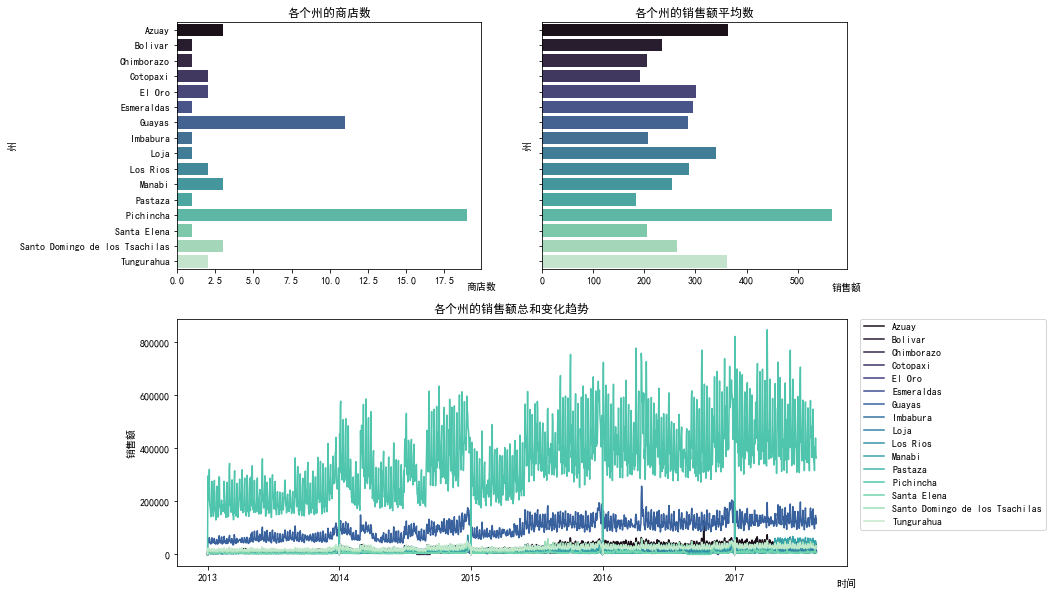

In [24]:
# 地理位置与销售额
## 州
plt.figure(figsize=(12, 10))
ax1 = plt.subplot(2,2,1)
sns.barplot(ax=ax1, 
            palette="mako",
            y=train_store.groupby(by=["state"])["store_nbr"].unique().index, 
            x=train_store.groupby(by=["state"])["store_nbr"].unique().apply(len)
           )
ax1.set(ylabel="州", xlabel="商店数", title="各个州的商店数")
ax1.xaxis.set_label_coords(1, -0.05)
ax2 = plt.subplot(2,2,2)
sns.barplot(ax=ax2, 
            palette="mako",
            y=train_store.groupby(by=["state"])["sales"].mean().index, 
            x=train_store.groupby(by=["state"])["sales"].mean()
           )
ax2.set(ylabel="州", xlabel="销售额", title="各个州的销售额平均数", yticklabels=[])
ax2.xaxis.set_label_coords(1, -0.05)
ax3 = plt.subplot(2,1,2)
sns.lineplot(ax=ax3,
             palette="mako",
             data=train_store.groupby(by=["state", "date"])["sales"].sum().reset_index(),
             x="date",
             y="sales",
             hue="state"
            )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax3.set(ylabel="销售额", xlabel="时间", title="各个州的销售额总和变化趋势")
ax3.xaxis.set_label_coords(1, -0.05)

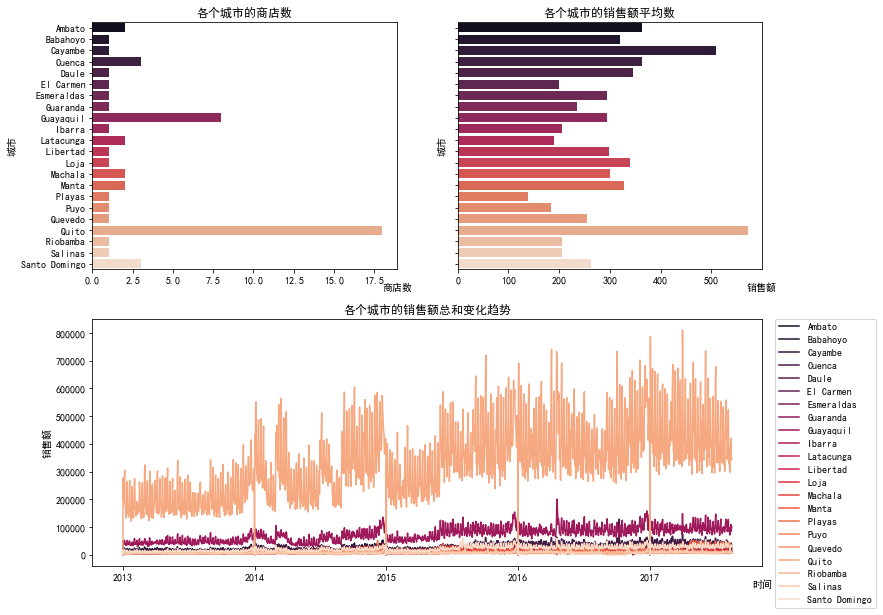

In [25]:
## 城市
plt.figure(figsize=(12, 10))
ax1 = plt.subplot(2,2,1)
sns.barplot(ax=ax1, 
            palette="rocket",
            y=train_store.groupby(by=["city"])["store_nbr"].unique().index, 
            x=train_store.groupby(by=["city"])["store_nbr"].unique().apply(len)
           )
ax1.set(ylabel="城市", xlabel="商店数", title="各个城市的商店数")
ax1.xaxis.set_label_coords(1, -0.05)
ax2 = plt.subplot(2,2,2)
sns.barplot(ax=ax2, 
            palette="rocket",
            y=train_store.groupby(by=["city"])["sales"].mean().index, 
            x=train_store.groupby(by=["city"])["sales"].mean()
           )
ax2.set(ylabel="城市", xlabel="销售额", title="各个城市的销售额平均数", yticklabels=[])
ax2.xaxis.set_label_coords(1, -0.05)
ax3 = plt.subplot(2,1,2)
sns.lineplot(ax=ax3,
             palette="rocket",
             data=train_store.groupby(by=["city", "date"])["sales"].sum().reset_index(),
             x="date",
             y="sales",
             hue="city"
            )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax3.set(ylabel="销售额", xlabel="时间", title="各个城市的销售额总和变化趋势")
ax3.xaxis.set_label_coords(1, -0.05)

<p style="line-height:2">
    少数州 / 城市的销售额显著高于其他州 / 城市，特别是 Pichincha 州的 Quito 市，销售额在所有城市中排名第一。
</p>

<strong> 商店类型 </strong>

<p style="line-height:2">
    不同类型的商店，销售额有明显差异吗？下面分析商店的 type 和 cluster 特征对销售额的影响。
</p>

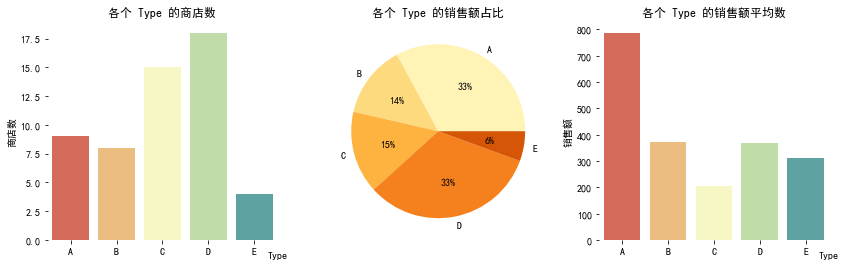

In [26]:
# 商店类型与销售额
## 特征：type
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.despine(bottom = True, left = True)
sns.barplot(ax=axs[0],
            x=train_store.groupby(by="type")["store_nbr"].unique().index, 
            y=train_store.groupby(by="type")["store_nbr"].unique().apply(len), 
            palette="Spectral"
           )
axs[0].set(xlabel="Type", ylabel="商店数", title="各个 Type 的商店数")
axs[0].xaxis.set_label_coords(1, -0.05)

type_sum = train_store.groupby(by="type")["sales"].sum()
axs[1].pie(type_sum / type_sum.sum(), 
           labels=type_sum.index.to_list(), 
           colors=sns.color_palette("YlOrBr"), 
           autopct='%.0f%%')
axs[1].set(title="各个 Type 的销售额占比")

sns.barplot(ax=axs[2], 
               x=train_store.groupby(by="type")["sales"].mean().index, 
               y=train_store.groupby(by="type")["sales"].mean(),
               palette="Spectral"
              )
axs[2].set(xlabel="Type", ylabel="销售额", title="各个 Type 的销售额平均数")
axs[2].xaxis.set_label_coords(1, -0.05)

<p style="line-height:2">
    Type 为 A 和 D 的商店销售额占比最大。其中 D 类商店数量最多，但平均销售额表现一般；A 类商店虽然数量排第三，平均销售额是其他类商店的两倍以上。
</p>

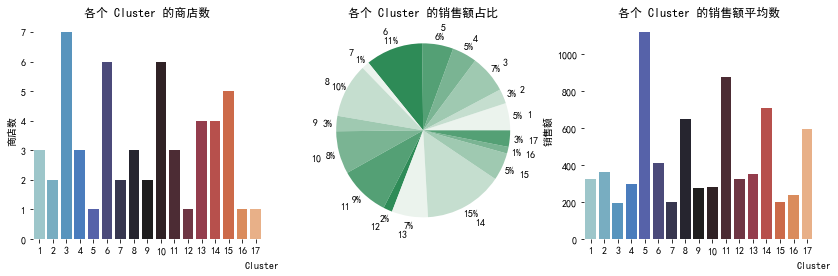

In [27]:
## cluster
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.despine(bottom = True, left = True)
sns.barplot(ax=axs[0],
            x=train_store.groupby(by="cluster")["store_nbr"].unique().index, 
            y=train_store.groupby(by="cluster")["store_nbr"].unique().apply(len), 
            palette="icefire"
           )
axs[0].set(xlabel="Cluster", ylabel="商店数", title="各个 Cluster 的商店数")
axs[0].xaxis.set_label_coords(1, -0.1)

type_sum = train_store.groupby(by="cluster")["sales"].sum()
axs[1].pie(type_sum / type_sum.sum(), 
           labels=type_sum.index.to_list(), 
           colors=sns.light_palette("seagreen"), 
           autopct='%.0f%%',
           pctdistance=1.1, 
           labeldistance=1.21
          )
axs[1].set(title="各个 Cluster 的销售额占比")

sns.barplot(ax=axs[2], 
               x=train_store.groupby(by="cluster")["sales"].mean().index, 
               y=train_store.groupby(by="cluster")["sales"].mean(),
               palette="icefire"
              )
axs[2].set(xlabel="Cluster", ylabel="销售额", title="各个 Cluster 的销售额平均数")
axs[2].xaxis.set_label_coords(1, -0.1)

<p style="line-height:2">
    相较 Type，Cluster 特征对超市的分类更细化。Cluster 14 的销售额占比最大，原因可能是 Cluster 14 的商店数量较多且销售额平均表现排名第三。
</p>

## 特征工程

<p style="line-height:2">
    本节将从数据表中提取特征，用于后续的数据建模。
</p>

> 提取特征的部分思路参考了 kaggle 社区讨论。

### 石油价格

<p style="line-height:2">
    将 2013 年 1 月 1 日至 2017 年 8 月 31 日的每日石油价格视作一个单变量时间序列，检验序列的 pacf。
</p>

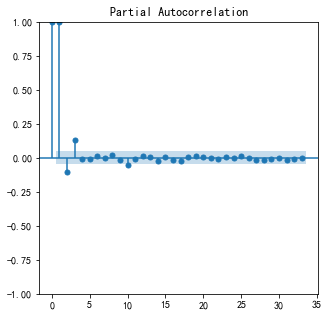

In [7]:
# pacf
oil_ts = oil.set_index("date")
oil_ts.index = pd.DatetimeIndex(oil_ts.index).to_period("D")

with plt.rc_context():
    plt.rc("figure", figsize=(5, 5))
    plot_pacf(oil_ts, method="ywm")
    plt.show()

<p style="line-height:2">
    pacf 的三阶滞后显著，据此提取石油价格的滞后特征。
</p>

In [9]:
for lag in range(1, 4):
    oil[f'oil_lags{lag}'] = oil["dcoilwtico"].shift(lag)
oil = oil.fillna(method="bfill")

<p style="line-height:2">
    增加特征：每周的石油平均价格。
</p>

In [10]:
oil["oil_week_avg"] = oil["dcoilwtico"].rolling(7).mean()
oil = oil.fillna(method="bfill")
oil

,date,dcoilwtico,oil_lags1,oil_lags2,oil_lags3,oil_week_avg
0,2013-01-01,93.14,93.14,93.140000,93.140000,93.137230
1,2013-01-02,93.14,93.14,93.140000,93.140000,93.137230
2,2013-01-03,92.97,93.14,93.140000,93.140000,93.137230
...,...,...,...,...,...,...
1701,2017-08-29,46.46,46.40,46.763127,47.583495,47.220946
1702,2017-08-30,45.96,46.46,46.400000,46.763127,46.865232
1703,2017-08-31,47.26,45.96,46.460000,46.400000,46.868089


<p style="line-height:2">
    合并 Oil 表。
</p>

In [11]:
def merge_oil(df):
    df = pd.merge(df, oil, on="date", how="left")
    return df

train = merge_oil(train)
test = merge_oil(test)

### 商店

<p style="line-height:2">
    增加特征：该商店是否为所在城市的唯一 Favorita 商店。
</p>

In [12]:
muti_stores = ["Quito", "Guayaquil", "Santo Domingo", "Cuenca", "Manta", "Machala", "Latacunga", "Ambato"] # 2.2.2 节
stores["unique_store"] = stores["city"].apply(lambda x: 0 if x in muti_stores else 1)

<p style="line-height:2">
    增加特征：该商店是否为 2013 年 1 月 1 日以后才开张营业的商店。
</p>

In [13]:
base_time = opening_time_df.iloc[0, 1]
new_stores = opening_time_df[opening_time_df["opening"] > base_time].store_nbr.to_list()
stores["new_store"] = stores["store_nbr"].apply(lambda x: 1 if x in new_stores else 0)
stores

,store_nbr,city,state,type,cluster,unique_store,new_store
0,1,Quito,Pichincha,D,13,0,0
1,2,Quito,Pichincha,D,13,0,0
2,3,Quito,Pichincha,D,8,0,0
...,...,...,...,...,...,...,...
51,52,Manta,Manabi,A,11,0,1
52,53,Manta,Manabi,D,13,0,1
53,54,El Carmen,Manabi,C,3,1,0


<p style="line-height:2">
    合并 Stores 表。
</p>

In [14]:
def merge_stores(df):
    df = pd.merge(df, stores, on="store_nbr", how="left")
    return df

train = merge_stores(train)
test = merge_stores(test)

### 节假日

<p style="line-height:2">
    根据 kaggle 官网的提示，删除 transferred 为 True 的节假日记录。之后删除 transferred 和 description 两列。
</p>

In [15]:
holidays = holidays[holidays["transferred"] == False].drop(columns=["transferred", "description"])

<p style="line-height:2">
    将节假日根据区域划分为不同的分表，然后合并到训练集和测试集。
</p>

In [16]:
national_holidays = holidays[holidays["locale"] == "National"].drop(columns=["locale", "locale_name"])
national_holidays.columns = ["date", "type_h"]

state_holidays = holidays[holidays["locale"] == "Regional"].drop(columns=["locale"])
state_holidays.columns = ["date", "type_h", "state"]

city_holidays = holidays[holidays["locale"] == "Local"].drop(columns=["locale"])
city_holidays.columns = ["date", "type_h", "city"]

def merge_holidays(df):
    df = pd.merge(df, national_holidays, on="date", how="left")
    df = pd.merge(df, state_holidays, on=["date", "state"], how="left")
    df = pd.merge(df, city_holidays, on=["date", "city"], how="left")
    df = df.fillna("")
    df["type_holidays"] = df["type_h_x"] + df["type_h_y"] + df["type_h"]
    df["type_holidays"] = df["type_holidays"].str.replace("Work Day", "")
    df["type_holidays"] = df["type_holidays"].str.replace(".+(Holiday)", "Holiday", regex=True)
    df = df.drop(columns=["type_h_x", "type_h_y", "type_h"])
    return df

train = merge_holidays(train)
test = merge_holidays(test)

### 交易数

<p style="line-height:2">
    对于 Transactions 表，先将其与训练集合并。缺失值处理：节假日的缺失交易数填充为 0，然后计算滑动平均，填充非节假日的缺失值。测试集的 transactions 特征均为 None。
</p>

In [17]:
train = pd.merge(train, transactions, on=["date", "store_nbr"], how="left")

# 节假日的交易数填充为 0
for i in range(train.shape[0]):
    if train.iloc[i, -2] != "" and np.isnan(train.iloc[i, -1]):
        train.iloc[i, -1] = 0

# 滑动平均
group_df = train.groupby(by=["store_nbr", "date"])["transactions"].first().reset_index()
group_df["avg_tra"] = group_df.transactions.rolling(15, min_periods=10).mean()
group_df.drop(columns="transactions", inplace=True)
train = train.merge(group_df, on=["date", "store_nbr"], how="left")
train.loc[train.transactions.isnull(), "transactions"] = train.avg_tra
train.drop(columns="avg_tra", inplace=True)
train["transactions"] = train.groupby(
                            by="store_nbr"
                        )["transactions"].apply(lambda group: group.interpolate(method="polynomial", order=2))

test["transactions"] = None

### 时间

<p style="line-height:2">
    增加特征：年、季度、月、日、星期、星期数。
</p>

In [18]:
def time_features(df):
    df["year"] = df["date"].dt.year
    df["quarter"] = df["date"].dt.quarter
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.day_of_week
    df["week_of_year"] = df["date"].dt.isocalendar().week
    return df

train = time_features(train)
test = time_features(test)

<p style="line-height:2">
    增加特征：时间周期信息。
</p>

In [19]:
day = 24 * 60 * 60
week = day * 7
year = 365.2425 * day
quarter = year / 4
half_decade = year * 5

def tri_time(df):
    timestamp_s = df["date"].map(pd.Timestamp.timestamp)
    
    df["week_sin"] = np.sin(timestamp_s * (2 * np.pi / week))
    df["week_cos"] = np.cos(timestamp_s * (2 * np.pi / week))

    df["quarter_sin"] = np.sin(timestamp_s * (2 * np.pi / quarter))
    df["quarter_cos"] = np.cos(timestamp_s * (2 * np.pi / quarter))

    df["year_sin"] = np.sin(timestamp_s * (2 * np.pi / year))
    df["year_cos"] = np.cos(timestamp_s * (2 * np.pi / year))    

    df["half_decade_sin"] = np.sin(timestamp_s * (2 * np.pi / half_decade))
    df["half_decade_cos"] = np.cos(timestamp_s * (2 * np.pi / half_decade))
    return df

train = tri_time(train)
test = tri_time(test)

<p style="line-height:2">
    增加特征：工作日。
</p>

In [20]:
def work_day(df):
    df["work_day"] = 1
    df.loc[(df["type_holidays"] != "") | (df["day_of_week"] > 4), "work_day"] = 0
    return df

train = work_day(train)
test = work_day(test)

<p style="line-height:2">
    根据 kaggle 官网提供的厄瓜多尔发薪日相关信息，增加特征：发薪日。
</p>

In [21]:
def wage_day(df):
    df["wage_day"] = ((df["date"].dt.day == 15) | (df["date"].dt.is_month_end)).astype(int)
    return df

train = wage_day(train)
test = wage_day(test)

<p style="line-height:2">
    增加特征：开学季。
</p>

In [22]:
def school_season(df):
    df["school_season"] = df["month"].apply(lambda x: 1 if x in (4, 5, 8, 9) else 0)
    return df

train = school_season(train)
test = school_season(test)

<p style="line-height:2">
    增加特征：特定商店每日促销商品数。
</p>

In [23]:
def daily_onpro(df):
    df["daily_onpro"] = df.groupby(by=["date", "store_nbr"]).onpromotion.transform(lambda x: x.sum())
    return df

train = daily_onpro(train)
test = daily_onpro(test)

### 编码与整合
<p style="line-height:2">
    为了编码方便，将原训练集分为 X 和 y，然后暂时合并训练集与测试集两张表。 
</p>

In [24]:
train_y = train["sales"]
train = train.drop(columns=["sales"])

train["label"] = pd.Series(np.ones(train.shape[0]))
test["label"] = pd.Series(np.zeros(test.shape[0]))
merged_df = pd.concat([train, test], axis=0)

<p style="line-height:2">
    对名义变量进行 one-hot 编码。
</p>

In [25]:
merged_df["location"] = merged_df["city"] + ", " + merged_df["state"]
merged_df = merged_df.drop(columns=["city", "state"])
merged_df = pd.get_dummies(merged_df, columns=["location"], drop_first=True)
merged_df = pd.get_dummies(merged_df, columns=["type"], drop_first=True)
merged_df = pd.get_dummies(merged_df, columns=["type_holidays"], drop_first=True)
merged_df = pd.get_dummies(merged_df, columns=["year"], drop_first=True)
merged_df = pd.get_dummies(merged_df, columns=["quarter"], drop_first=True)
merged_df = pd.get_dummies(merged_df, columns=["month"], drop_first=True)
merged_df = pd.get_dummies(merged_df, columns=["day_of_week"], drop_first=True)

<p style="line-height:2">
    处理完毕的 train 和 test 表。
</p>

In [26]:
train = merged_df[merged_df["label"] == 1].drop(columns=["label"])
test = merged_df[merged_df["label"] == 0].drop(columns=["label"])
train["y"] = train_y

In [47]:
train

,id,date,store_nbr,family,onpromotion,dcoilwtico,oil_lags1,oil_lags2,oil_lags3,oil_week_avg,...,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,y
0,0,2013-01-01,1,AUTOMOTIVE,0,93.14,93.14,93.140000,93.140000,93.137230,...,0,0,0,1,0,0,0,0,0,0.000
1,1,2013-01-01,1,BABY CARE,0,93.14,93.14,93.140000,93.140000,93.137230,...,0,0,0,1,0,0,0,0,0,0.000
2,2,2013-01-01,1,BEAUTY,0,93.14,93.14,93.140000,93.140000,93.137230,...,0,0,0,1,0,0,0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787408,3000885,2017-08-15,9,PRODUCE,148,47.57,47.59,47.939482,48.684203,48.389098,...,0,0,0,1,0,0,0,0,0,2419.729
2787409,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,47.57,47.59,47.939482,48.684203,48.389098,...,0,0,0,1,0,0,0,0,0,121.000
2787410,3000887,2017-08-15,9,SEAFOOD,0,47.57,47.59,47.939482,48.684203,48.389098,...,0,0,0,1,0,0,0,0,0,16.000


In [48]:
test

,id,date,store_nbr,family,onpromotion,dcoilwtico,oil_lags1,oil_lags2,oil_lags3,oil_week_avg,...,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.80,47.57,47.59,47.939482,47.990526,...,0,0,0,0,0,1,0,0,0,0
1,3000889,2017-08-16,1,BABY CARE,0,46.80,47.57,47.59,47.939482,47.990526,...,0,0,0,0,0,1,0,0,0,0
2,3000890,2017-08-16,1,BEAUTY,2,46.80,47.57,47.59,47.939482,47.990526,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28509,3029397,2017-08-31,9,PRODUCE,1,47.26,45.96,46.46,46.400000,46.868089,...,0,0,0,0,0,0,1,0,0,0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26,45.96,46.46,46.400000,46.868089,...,0,0,0,0,0,0,1,0,0,0
28511,3029399,2017-08-31,9,SEAFOOD,0,47.26,45.96,46.46,46.400000,46.868089,...,0,0,0,0,0,0,1,0,0,0


# 数据建模

<p style="line-height:2">
    本节对数据进行建模，目标是预测 2017 年 8 月 16 日至 2017 年 8 月 31 日各家商店的各种商品类型销售额。本节应用的模型包括了：时间序列模型、机器学习模型、深度学习模型。基于 2.2 节对销售额的探索性分析结果，数据建模时采用的 <b> 基本策略 </b> 是：对每一家商店的每一种商品类型 <b> 分别 </b> 建立一个模型。
</p>

## 时间序列模型

### ARIMA(1, 0, 1)

<p style="line-height:2">
    给定商店的某一商品类型销售额可以视作一组单变量时间序列，下面以商店 1 的 AUTOMOTIVE 商品类型为例，进行简要分析。
</p>

In [86]:
# ARIMA: 样例
trial = train.loc[(train["store_nbr"] == 1) & (train["family"] == "AUTOMOTIVE"), ["date", "y"]]
trial = trial.set_index("date")
trial.index = pd.DatetimeIndex(trial.index).to_period('D')

# Augmented Dickey Fuller test
result = adfuller(trial)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

ADF Statistic: -4.022264889389601
p-value: 0.0012983097149300948
Critial Values:
   1%, -3.4342859473725906
Critial Values:
   5%, -2.8632784969542016
Critial Values:
   10%, -2.56769553371452


<p style="line-height:2">
    p 值小于 0.05，因此可以在 0.05 的水平上拒绝原假设，认为该时间序列是平稳的。
</p>

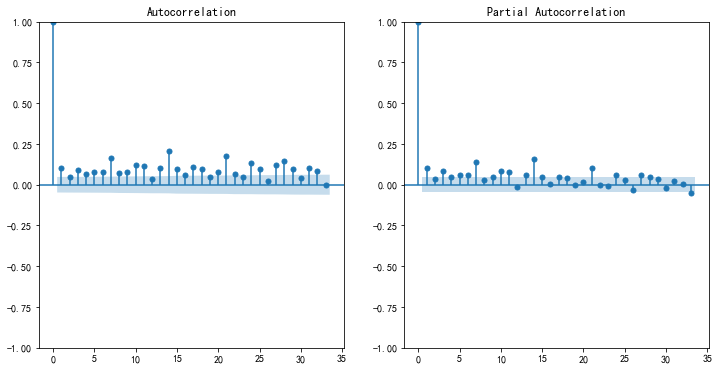

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(trial, ax=ax[0])
plot_pacf(trial, method="ywm", ax=ax[1])
plt.show()

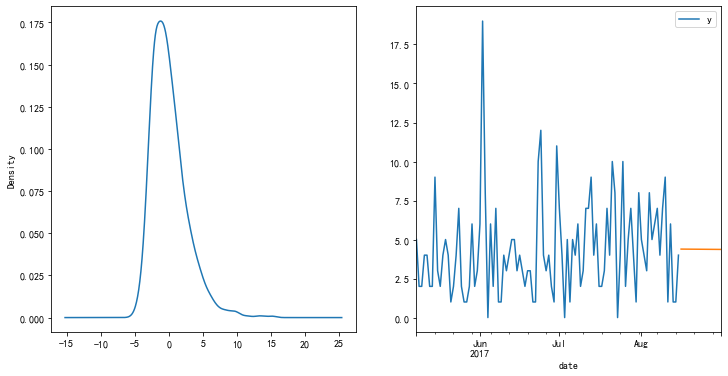

In [88]:
model = ARIMA(trial, order=(1, 0, 1))
model_fit = model.fit()
model_fit.summary()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
model_fit.resid.plot(kind="kde", ax=ax[0]) # 检查残差

forecast = model_fit.predict(start=datetime.datetime(2017, 8, 16), end=datetime.datetime(2017, 8, 31)) # 预测

# 结果可视化
trial[-100:].plot(ax=ax[1])
forecast.plot(ax=ax[1])
plt.show()

<p style="line-height:2">
    拟合结果还行。做一个简单假设：每一家商店的每一种商品类型的销售额均符合单变量 ARIMA(1, 0, 1) 模型。在此基础上，尝试进行建模和预测。
</p>

In [89]:
# ARIMA(1, 0, 1)

COL = ["date", "sales", "family", "store_nbr"]
pre_df = pd.DataFrame(data=None, columns=COL)

def one_trial(keys, pre_df):
    i_store = keys[0]
    i_family = keys[1]
    trial = train.loc[(train["store_nbr"] == i_store) & (train["family"] == i_family), ["date", "y"]]
    trial = trial.set_index("date")
    trial.index = pd.DatetimeIndex(trial.index).to_period('D')
    
    model = ARIMA(trial, order=(1, 0, 1))
    model_fit = model.fit()
    forecast = model_fit.predict(start=datetime.datetime(2017, 8, 16), end=datetime.datetime(2017, 8, 31))
    forecast = pd.DataFrame(forecast).reset_index()
    forecast["family"] = i_family
    forecast["store_nbr"] = i_store
    forecast.columns = ["date", "sales", "family", "store_nbr"]
    pre_df = pd.concat([pre_df, forecast], axis=0)
        
    return pre_df

In [90]:
%%time
i = 1
for t in itertools.product(train_store_nbr, train_family):
    pre_df = one_trial(t, pre_df)
    if (i % 100) == 0:
        print(f"提示：已运行{i}轮。")
    i += 1

C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\stats

提示：已运行100轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anacond

提示：已运行200轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packa

提示：已运行300轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\states

提示：已运行400轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sari

提示：已运行500轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\1250

提示：已运行600轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anacond

提示：已运行700轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packa

提示：已运行800轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packa

提示：已运行900轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramete

提示：已运行1000轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramete

提示：已运行1100轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


提示：已运行1200轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packa

提示：已运行1300轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


提示：已运行1400轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


提示：已运行1500轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12502\anaconda3\lib\site-packa

提示：已运行1600轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\1250

提示：已运行1700轮。


C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12502\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\1250

CPU times: total: 1h 18min 43s
Wall time: 13min 2s


In [91]:
pre_df["date"] = pd.to_datetime(pre_df["date"].astype(str))
my_pre = pd.merge(test, pre_df, how="left", on=["date", "store_nbr", "family"])
my_pre = my_pre.loc[:, ["id", "sales"]]
my_pre.loc[my_pre["sales"] < 0, "sales"] = 0
my_pre.to_csv(re_path + "sub.csv", index=False)

<p style="line-height:2">
    CPU 运行时长为：1h 18min 43s；实际运行时长为：13min 2s；在测试集上的最佳 RMSE 为 0.47291。
</p>

### 自动选择 ARIMA 模型

<p style="line-height:2">
    本小节利用 pmdarima 库实现 ARIMA 模型的自动识别，并在此基础上完成预测。
</p>

In [27]:
# Auto ARIMA：样例
trial = train.loc[(train["store_nbr"] == 1) & (train["family"] == "AUTOMOTIVE"), ["date", "y"]]
trial = trial.set_index("date")
trial.index = pd.DatetimeIndex(trial.index).to_period('D')

model = auto_arima(trial, start_p=0, start_q=0, start_P=0, start_Q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1688
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -4031.336
Date:                Thu, 16 Jun 2022   AIC                           8070.671
Time:                        15:10:05   BIC                           8092.394
Sample:                             0   HQIC                          8078.716
                               - 1688                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9794      0.026    -38.111      0.000      -1.030      -0.929
ma.L2         -0.0653      0.036     -1.794      0.073      -0.137       0.006
ma.L3          0.0633      0.026      2.405      0.016       0.012       0.115
sigma2         6.9547      0.150     46.422      0.000       6.661       7.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1265.37
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                             1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

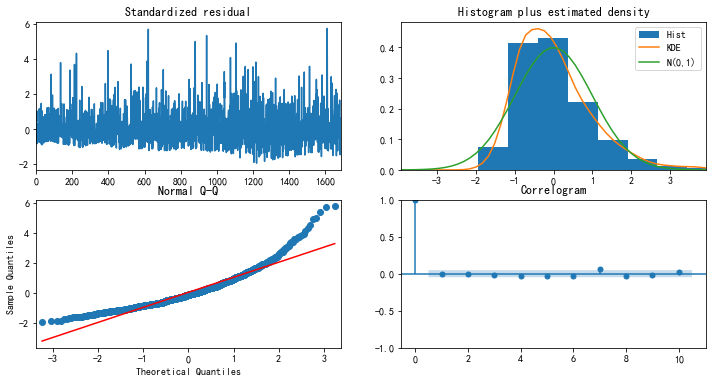

In [36]:
# 模型诊断
with plt.rc_context():
    plt.rc("figure", figsize=(12, 6))
    model.plot_diagnostics()
    plt.show()

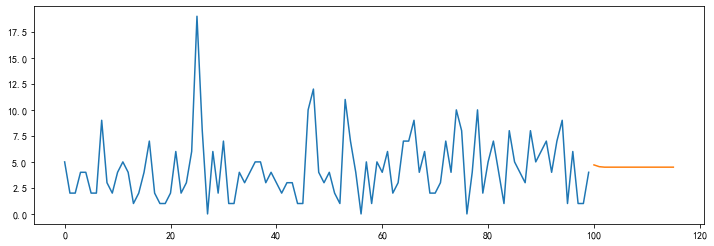

In [41]:
# 预测
forecast = model.predict(n_periods=16)

# 结果可视化
with plt.rc_context():
    plt.rc("figure", figsize=(12, 4))
    plt.plot(range(100), trial.iloc[-100:, -1])
    plt.plot(range(100, 116), forecast)
    plt.show()

In [43]:
# Auto ARIMA

class AutoARIMA():
    
    COL = ["date", "sales", "family", "store_nbr"]
    store_nbr = train_store_nbr
    family = train_family
    
    def __init__(self, out_path=re_path):
        self.con = True
        self.out_path = out_path
        if not os.path.exists(self.out_path + "tracker_arima.csv"):
            self.create_tracker()
            
    def create_tracker(self):
        store_lst = []
        family_lst = []
        it_lst = []
        
        for t in itertools.product(AutoARIMA.store_nbr, AutoARIMA.family):
            store_lst.append(t[0])
            family_lst.append(t[1])
            it_lst.append(0)
            
        tracker = pd.DataFrame({"store_nbr": store_lst, "family": family_lst, "it": it_lst})
        tracker.to_csv(self.out_path + "tracker_arima.csv", index=False)
        
    def one_trial_auto(self):
        self.tracker = pd.read_csv(self.out_path + "tracker_arima.csv")
        self.tracker = self.tracker[self.tracker["it"] == 0]
        print(f"进度：{1782 - self.tracker.shape[0]} / 1782")
        if self.tracker.shape[0] == 1:
            self.con = False
            print("提示：预测即将完成")
        
        one_key = self.tracker.sample(n=1)
        i_store = one_key.iloc[i, 0]
        i_family = one_key.iloc[i, 1]
        
        if not os.path.exists(self.out_path + "arima_pre.csv"):
            self.pre_df = pd.DataFrame(data=None, columns=AutoARIMA.COL)
        else:
            self.pre_df = pd.read_csv(self.out_path + "arima_pre.csv")
            
        trial = train.loc[(train["store_nbr"] == i_store) & (train["family"] == i_family), ["date", "y"]]
        trial = trial.set_index("date")
        trial.index = pd.DatetimeIndex(trial.index).to_period('D')

        model = auto_arima(trial, start_p=0, start_q=0, start_P=0, start_Q=0)
        forecast = model.predict(n_periods=16)
        forecast_df = pd.DataFrame({"date": pd.date_range(start='2017-08-16', end='2017-08-31'), 
                                    "sales":pd.Series(forecast)})
        forecast_df["family"] = i_family
        forecast_df["store_nbr"] = i_store
        forecast_df.columns = ["date", "sales", "family", "store_nbr"]
        self.pre_df = pd.concat([self.pre_df, forecast_df], axis=0)
        
        self.pre_df.to_csv(self.out_path + "arima_pre.csv", index=False)
        
        self.tracker.loc[(self.tracker["store_nbr"] == i_store) & (self.tracker["family"] == i_family), "it"] = 1
        self.tracker.to_csv(self.out_path + "tracker_arima.csv", index=False)
        
    def main(self):
        self.tracker = pd.read_csv(self.out_path + "tracker_arima.csv")
        self.tracker = self.tracker[self.tracker["it"] == 0]
        if self.tracker.shape[0] == 0:
            self.con = False
            print("提示：预测已完成")
        
        while self.con:
            self.one_trial_auto()

<p style="line-height:2">
    <b>该方法速度非常慢</b>，我是直接在终端里运行根目录下的 auto_arima.py 脚本。
</p>

In [5]:
arima_pre = pd.read_csv(re_path + "arima_pre.csv")
arima_pre["date"] = pd.to_datetime(arima_pre["date"])
my_pre = pd.merge(test, arima_pre, how="left", on=["date", "store_nbr", "family"])
my_pre = my_pre.loc[:, ["id", "sales"]]
my_pre.loc[my_pre["sales"] < 0, "sales"] = 0
my_pre.to_csv(re_path + "sub.csv", index=False)

<p style="line-height:2">
    实际运行时长约为七小时，在测试集上的最佳 RMSE 为 0.45133。
</p>

## LSTM 模型

<p style="line-height:2">
    本小节利用深度学习中的 LSTM 模型，实现对商店销量的预测。首先，还是以商店 1 的 AUTOMOTIVE 商品类型为例，进行模型搭建和超参调节。
</p>

In [131]:
# lstm：样例
## 超参设置
N_EPOCH = 50
BATCH = 64
TIME = 14
FEATURES = 77
HIDDEN_UNITS_1 = 128
HIDDEN_UNITS_2 = 64
OUT = 16

# 筛选
trial = train[(train["store_nbr"] == 1) & (train["family"] == "AUTOMOTIVE")]
trial = trial.drop(columns=["id", "date", "store_nbr", "family", "transactions"])

# 训练集 / 验证集划分：调节超参
trial_train_x = trial.iloc[:-400, :-1].to_numpy()
trial_train_y = trial.iloc[:-400, -1].to_numpy()
trial_val_x = trial.iloc[-400:, :-1].to_numpy()
trial_val_y = trial.iloc[-400:, -1].to_numpy()

# 训练集 / 测试集划分：模型评估
trial_x = trial.iloc[:, :-1].to_numpy()
trial_y = trial.iloc[:, -1].to_numpy()
trial_t = test[(test["store_nbr"] == 1) & (test["family"] == "AUTOMOTIVE")]
trial_t = trial_t.drop(columns=["id", "date", "store_nbr", "family", "transactions"]).to_numpy()

trial_train_x = proper_np(trial_train_x)
trial_val_x = proper_np(trial_val_x)
trial_x = proper_np(trial_x)
trial_t = proper_np(trial_t)

# 分别创建 TF 数据集
train_data1 = tf.keras.utils.timeseries_dataset_from_array(trial_train_x, trial_train_y, TIME, batch_size=BATCH)
val_data = tf.keras.utils.timeseries_dataset_from_array(trial_val_x, trial_val_y, TIME, batch_size=BATCH)

train_data2 = tf.keras.utils.timeseries_dataset_from_array(trial_x, trial_y, TIME, batch_size=BATCH)
test_data = tf.keras.utils.timeseries_dataset_from_array(trial_t, None, TIME, batch_size=BATCH)

def lstm_model(summary=True):
    inputs = tf.keras.Input(shape=(TIME, FEATURES))
    x = tf.keras.layers.LSTM(HIDDEN_UNITS_1, activation="relu", return_sequences=True)(inputs)
    x = tf.keras.layers.LSTM(HIDDEN_UNITS_2, activation="relu")(x)
    outputs = tf.keras.layers.Dense(OUT)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="Adam", loss="mse", metrics=["mse"])
    if summary:
        model.summary()
    return model

# 训练并调节超参
tf.keras.backend.clear_session()
model = lstm_model()
history = model.fit(train_data1, validation_data=val_data, epochs=N_EPOCH)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 77)]          0         
                                                                 
 lstm (LSTM)                 (None, 14, 128)           105472    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
Total params: 155,920
Trainable params: 155,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
20/20 [==============================] - 3s 57ms/step - loss: 885.8952 - mse: 885.8952 - val_loss: 593.5435 - val_mse: 593.5435
Epoch 2/50
20/20 [==============================

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


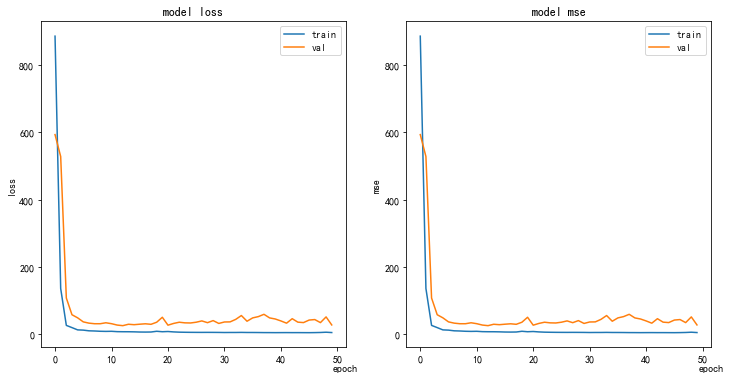

In [136]:
print(history.history.keys())

# 模型评估结果可视化
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# summarize history for loss
ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].title.set_text("model loss")
ax[0].set_ylabel("loss")
ax[0].set_xlabel("epoch")
ax[0].legend(["train", "val"], loc='upper right')
ax[0].xaxis.set_label_coords(1, -0.05)

# summarize history for mse
ax[1].plot(history.history["mse"])
ax[1].plot(history.history["val_mse"])
ax[1].title.set_text("model mse")
ax[1].set_ylabel("mse")
ax[1].set_xlabel("epoch")
ax[1].legend(["train", "val"], loc='upper right')
ax[1].xaxis.set_label_coords(1, -0.05)
plt.show()

In [137]:
# 训练并预测
N_EPOCH = 10

tf.keras.backend.clear_session()
model = lstm_model(False)
model.fit(train_data2, epochs=N_EPOCH, verbose=0)
trial_pre = model.predict(test_data, verbose=0)

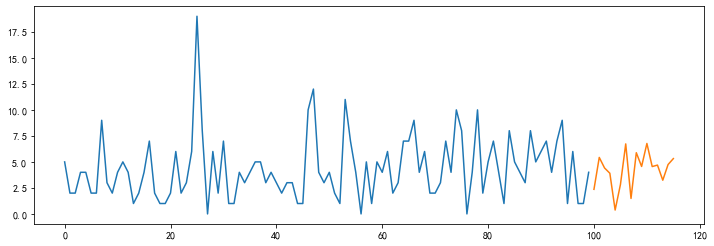

In [144]:
# 预测结果可视化
trial_pre_16 = trial_pre[0, :]
with plt.rc_context():
    plt.rc("figure", figsize=(12, 4))
    plt.plot(range(100), trial.iloc[-100:, -1])
    plt.plot(range(100, 116), trial_pre_16)
    plt.show()

<p style="line-height:2">
    对所有商店的所有商品类型进行分别建模。
</p>

In [147]:
# lstm

class MyLSTM():

    TIME = 14
    FEATURES = 77
    HIDDEN_UNITS_1 = 128
    HIDDEN_UNITS_2 = 64
    OUT = 16
    COL = ["date", "sales", "family", "store_nbr"]
    store_nbr = train_store_nbr
    family = train_family
    
    def __init__(self, train_df, test_df, in_path=base_path, out_path=re_path, n_epoch=10, n_batch=64):
        self.train_df = train_df
        self.test_df = test_df
        self.in_path = in_path
        self.out_path = out_path
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        
        if not os.path.exists(self.out_path + "tracker.csv"):
            self.create_tracker()
    
    def proper_np(self, X):
        """
        numpy: object->float32
        """
        X = np.asarray(X).astype(np.float32)
        return X

    def one_trial(self, i_store, i_family):
        if not os.path.exists(self.out_path + "lstm_pre.csv"):
            self.pre_df = pd.DataFrame(data=None, columns=MyLSTM.COL)
        else:
            self.pre_df = pd.read_csv(self.out_path + "lstm_pre.csv")
        
        trial = self.train_df[(self.train_df["store_nbr"] == i_store) & (self.train_df["family"] == i_family)]
        trial = trial.drop(columns=["id", "date", "store_nbr", "family", "transactions"])
        trial_x = trial.iloc[:, :-1].to_numpy()
        trial_y = trial.iloc[:, -1].to_numpy()
        trial_t = self.test_df[(self.test_df["store_nbr"] == i_store) & (self.test_df["family"] == i_family)]
        trial_t = trial_t.drop(columns=["id", "date", "store_nbr", "family", "transactions"]).to_numpy()
        
        trial_x = self.proper_np(trial_x)
        trial_t = self.proper_np(trial_t)
        
        train_data = tf.keras.utils.timeseries_dataset_from_array(trial_x, trial_y, MyLSTM.TIME, batch_size=self.n_batch)
        test_data = tf.keras.utils.timeseries_dataset_from_array(trial_t, None, MyLSTM.TIME, batch_size=self.n_batch)
        
        tf.keras.backend.clear_session()
        
        inputs = tf.keras.Input(shape=(MyLSTM.TIME, MyLSTM.FEATURES))
        x = tf.keras.layers.LSTM(MyLSTM.HIDDEN_UNITS_1, activation="relu", return_sequences=True)(inputs)
        x = tf.keras.layers.LSTM(MyLSTM.HIDDEN_UNITS_2, activation="relu")(x)
        outputs = tf.keras.layers.Dense(MyLSTM.OUT)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        model.compile(optimizer="Adam", loss="mse", metrics=["mse"])
        model.fit(train_data, epochs=self.n_epoch, verbose=0)
        trial_pre = model.predict(test_data, verbose=0)
        trial_pre_16 = trial_pre[0, :]
        
        trial_pre_df = pd.DataFrame({"date": pd.date_range(start='2017-08-16', end='2017-08-31'), 
                                     "sales":pd.Series(trial_pre_16)})
        trial_pre_df["family"] = i_family
        trial_pre_df["store_nbr"] = i_store
        trial_pre_df.columns = ["date", "sales", "family", "store_nbr"]
        self.pre_df = pd.concat([self.pre_df, trial_pre_df], axis=0)
        self.pre_df.to_csv(self.out_path + "lstm_pre.csv", index=False)
        
        self.tracker.loc[(self.tracker["store_nbr"] == i_store) & (self.tracker["family"] == i_family), "it"] = 1
        self.tracker.to_csv(self.out_path + "tracker.csv", index=False)
        
    def create_tracker(self):
        store_lst = []
        family_lst = []
        it_lst = []
        
        for t in itertools.product(MyLSTM.store_nbr, MyLSTM.family):
            store_lst.append(t[0])
            family_lst.append(t[1])
            it_lst.append(0)
            
        tracker = pd.DataFrame({"store_nbr": store_lst, "family": family_lst, "it": it_lst})
        tracker.to_csv(self.out_path + "tracker.csv", index=False)
    
    def main(self):
        self.tracker = pd.read_csv(self.out_path + "tracker.csv")
        self.tracker = self.tracker[self.tracker["it"] == 0]
        
        for i in tqdm(range(self.tracker.shape[0])):
            self.one_trial(self.tracker.iloc[i, 0], self.tracker.iloc[i, 1])

In [148]:
%%time
run_lstm = MyLSTM(train, test)
run_lstm.main()

100%|████████████████████████████████████████████████████████████████████████████| 1782/1782 [6:21:01<00:00, 12.83s/it]

CPU times: total: 18h 25min 3s
Wall time: 6h 21min 1s


In [149]:
lstm_pre = pd.read_csv(re_path + "lstm_pre.csv")
lstm_pre["date"] = pd.to_datetime(lstm_pre["date"])
my_pre = pd.merge(test, lstm_pre, how="left", on=["date", "store_nbr", "family"])
my_pre = my_pre.loc[:, ["id", "sales"]]
my_pre.loc[my_pre["sales"] < 0, "sales"] = 0
my_pre.to_csv(re_path + "sub.csv", index=False)

<p style="line-height=2">
    CPU 运行时长为：18h 25min 3s；实际运行时长为：6h 21min 1s；在测试集上的最佳 RMSE 为 0.64427。
</p>

## 混合模型

<p style="line-height:2">
    本小节采用混合模型策略对商店销量进行预测。混合模型中共包含七个机器学习子模型：线性回归、岭回归、Lasso 回归、支持向量回归、随机森林回归、梯度提升回归、XGBoost 回归。预测有两种方案：
</p>

<ol style="line-height:2">
  <li>选择模型评估阶段表现最好的两个模型，取它们的预测平均值作为预测结果。</li>
  <li>选择模型评估阶段表现最好的模型，然后用于训练集预测。</li>
</ol>

<p style="line-height:2">
    下面是混合模型的代码实现。
</p>

In [31]:
# 混合模型

class HybridRegressor():
    
    COL = ["date", "sales", "family", "store_nbr"]
    store_nbr = train_store_nbr
    family = train_family
    
    def __init__(self, train_df, test_df, in_path=base_path, out_path=re_path):
        self.train_df = train_df
        self.test_df = test_df
        self.in_path = in_path
        self.out_path = out_path
        
        if not os.path.exists(self.out_path + "tracker2.csv"):
            self.create_tracker()
            
    def create_tracker(self):
        store_lst = []
        family_lst = []
        it_lst = []
        
        for t in itertools.product(HybridRegressor.store_nbr, HybridRegressor.family):
            store_lst.append(t[0])
            family_lst.append(t[1])
            it_lst.append(0)
            
        tracker = pd.DataFrame({"store_nbr": store_lst, "family": family_lst, "it": it_lst})
        tracker.to_csv(self.out_path + "tracker2.csv", index=False)
        
    def data_pre(self, i_store, i_family, val=True):
        trial = self.train_df[(self.train_df["store_nbr"] == i_store) & (self.train_df["family"] == i_family)]
        trial = trial.drop(columns=["id", "date", "store_nbr", "family", "transactions"])
        
        if val:
            trial_train_x = trial.iloc[:-15, :-1].to_numpy()
            trial_train_y = trial.iloc[:-15, -1].to_numpy()
            trial_val_x = trial.iloc[-15:, :-1].to_numpy()
            trial_val_y = trial.iloc[-15:, -1].to_numpy()
            return trial_train_x, trial_train_y, trial_val_x, trial_val_y
        else:
            trial_x = trial.iloc[:, :-1].to_numpy()
            trial_y = trial.iloc[:, -1].to_numpy()
            trial_t = self.test_df[(self.test_df["store_nbr"] == i_store) & (self.test_df["family"] == i_family)]
            trial_t = trial_t.drop(columns=["id", "date", "store_nbr", "family", "transactions"]).to_numpy()
            return trial_x, trial_y, trial_t
        
    def reg(self, x_tr, y_tr, x_te, y_te, para=0):
        if para == 0:
            model = linear_model.LinearRegression()
        elif para == 1:
            model = linear_model.Ridge(alpha=0.5)
        elif para == 2:
            model = linear_model.Lasso(alpha=0.1)
        elif para == 3:
            model = svm.SVR()
        elif para == 4:
            model = RandomForestRegressor()
        elif para == 5:
            model = GradientBoostingRegressor()
        elif para == 6:
            model = XGBRegressor()
        else:
            raise ValueError("para is invalid.")
        model.fit(x_tr, y_tr)
        pred = model.predict(x_te)
        pred_score = mean_squared_error(y_te, pred, squared=False)
        return pred_score, model
    
    def one_trial(self, i_store, i_family):
        if not os.path.exists(self.out_path + "hybrid_pre.csv"):
            self.pre_df = pd.DataFrame(data=None, columns=HybridRegressor.COL)
        else:
            self.pre_df = pd.read_csv(self.out_path + "hybrid_pre.csv")
        
        trial_train_x, trial_train_y, trial_val_x, trial_val_y = self.data_pre(i_store, i_family)
        pred1, model1 = self.reg(trial_train_x, trial_train_y, trial_val_x, trial_val_y, 5)
        pred2, model2 = self.reg(trial_train_x, trial_train_y, trial_val_x, trial_val_y, 6)
        if pred1 > pred2:
            pred_t, model_t = pred1, model1
            pred1, model1 = pred2, model2
            pred2, model2 = pred_t, model_t
        
        for i in range(5):
            pred_t, model_t = self.reg(trial_train_x, trial_train_y, trial_val_x, trial_val_y, i)
            if pred_t < pred2:
                pred2, model2 = pred_t, model_t
                if pred_t < pred1:
                    pred_t, model_t = pred1, model1
                    pred1, model1 = pred2, model2
                    pred2, model2 = pred_t, model_t
                    
        hreg = VotingRegressor([("top1", model1), ("top2", model2)])
        trial_x, trial_y, trial_t = self.data_pre(i_store, i_family, False)
        hreg.fit(trial_x, trial_y)
        trial_pre = hreg.predict(trial_t)
        
        trial_pre_df = pd.DataFrame({"date": pd.date_range(start='2017-08-16', end='2017-08-31'), 
                                     "sales":pd.Series(trial_pre)})
        trial_pre_df["family"] = i_family
        trial_pre_df["store_nbr"] = i_store
        trial_pre_df.columns = ["date", "sales", "family", "store_nbr"]
        self.pre_df = pd.concat([self.pre_df, trial_pre_df], axis=0)
        self.pre_df.to_csv(self.out_path + "hybrid_pre.csv", index=False)
        
        self.tracker.loc[(self.tracker["store_nbr"] == i_store) & (self.tracker["family"] == i_family), "it"] = 1
        self.tracker.to_csv(self.out_path + "tracker2.csv", index=False)
    
    def one_trial_best(self, i_store, i_family):
        if not os.path.exists(self.out_path + "hybrid_pre.csv"):
            self.pre_df = pd.DataFrame(data=None, columns=HybridRegressor.COL)
        else:
            self.pre_df = pd.read_csv(self.out_path + "hybrid_pre.csv")
        
        trial_train_x, trial_train_y, trial_val_x, trial_val_y = self.data_pre(i_store, i_family)
        pred, model = self.reg(trial_train_x, trial_train_y, trial_val_x, trial_val_y, 6)
        
        for i in range(6):
            pred_t, model_t = self.reg(trial_train_x, trial_train_y, trial_val_x, trial_val_y, i)
            if pred_t < pred:
                pred, model = pred_t, model_t
                
        trial_x, trial_y, trial_t = self.data_pre(i_store, i_family, False)
        model.fit(trial_x, trial_y)
        trial_pre = model.predict(trial_t)
        
        trial_pre_df = pd.DataFrame({"date": pd.date_range(start='2017-08-16', end='2017-08-31'), 
                                     "sales":pd.Series(trial_pre)})
        trial_pre_df["family"] = i_family
        trial_pre_df["store_nbr"] = i_store
        trial_pre_df.columns = ["date", "sales", "family", "store_nbr"]
        self.pre_df = pd.concat([self.pre_df, trial_pre_df], axis=0)
        self.pre_df.to_csv(self.out_path + "hybrid_pre.csv", index=False)
        
        self.tracker.loc[(self.tracker["store_nbr"] == i_store) & (self.tracker["family"] == i_family), "it"] = 1
        self.tracker.to_csv(self.out_path + "tracker2.csv", index=False)
    
    def main(self, best=False):
        self.tracker = pd.read_csv(self.out_path + "tracker2.csv")
        self.tracker = self.tracker[self.tracker["it"] == 0]
        
        for i in tqdm(range(self.tracker.shape[0])):
            if best:
                self.one_trial_best(self.tracker.iloc[i, 0], self.tracker.iloc[i, 1])       
            else:
                self.one_trial(self.tracker.iloc[i, 0], self.tracker.iloc[i, 1])        

<p style="line-height:2">
    首先，七个模型中选两个在验证集上表现最好的模型，取两个模型的预测平均值。
</p>

In [32]:
%%time
run_reg = HybridRegressor(train, test)
run_reg.main()

  0%|                                                                               | 1/1782 [00:02<1:05:52,  2.22s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
  0%|▏                                                                                | 3/1782 [00:04<49:48,  1.68s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.242e+07, tolerance: 8.838e+04
  model = cd_fast.enet_coordinate_descent(
  0%|▏                                                    

  1%|▉                                                                             | 21/1782 [00:54<1:16:09,  2.59s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.718e+01, tolerance: 5.470e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.293e+02, tolerance: 5.548e+00
  model = cd_fast.enet_coordinate_descent(
  1%|▉                                                                             | 22/1782 [00:57<1:14:06,  2.53s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

  3%|█▉                                                                            | 45/1782 [02:00<1:29:38,  3.10s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e+08, tolerance: 7.936e+04
  model = cd_fast.enet_coordinate_descent(
  3%|██▏                                                                           | 51/1782 [02:17<1:13:08,  2.54s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+06, tolerance: 1.851e+03
  model = cd_fast.enet_coordinate_descent(
  3%|██▎                                                  

  4%|███▍                                                                          | 78/1782 [03:30<1:22:47,  2.91s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.375e+09, tolerance: 7.279e+05
  model = cd_fast.enet_coordinate_descent(
  5%|███▌                                                                          | 81/1782 [03:39<1:22:57,  2.93s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.615e+03, tolerance: 1.101e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e+05, tolerance: 9.775e+02
  model = cd_fast.enet_coordinate_descent(
  6%|████▌                                                                        | 105/1782 [04:41<1:06:11,  2.37s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e+02, tolerance: 1.125e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number

  8%|█████▊                                                                       | 135/1782 [06:04<1:09:16,  2.52s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.743e+07, tolerance: 5.617e+04
  model = cd_fast.enet_coordinate_descent(
  8%|█████▉                                                                       | 136/1782 [06:08<1:17:55,  2.84s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
  8%|██████                                               

  9%|██████▊                                                                      | 157/1782 [07:03<1:09:54,  2.58s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e+06, tolerance: 9.278e+02
  model = cd_fast.enet_coordinate_descent(
  9%|██████▉                                                                      | 160/1782 [07:12<1:13:02,  2.70s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.624e+05, tolerance: 5.941e+02
  model = cd_fast.enet_coordinate_descent(
  9%|██████▉                                              

 10%|███████▉                                                                     | 183/1782 [08:17<1:08:06,  2.56s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.480e+06, tolerance: 3.142e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.380e+06, tolerance: 3.150e+03
  model = cd_fast.enet_coordinate_descent(
 10%|███████▉                                                                     | 184/1782 [08:20<1:07:32,  2.54s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 12%|█████████                                                                    | 209/1782 [09:28<1:17:43,  2.96s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+05, tolerance: 6.651e+02
  model = cd_fast.enet_coordinate_descent(
 12%|█████████                                                                    | 210/1782 [09:31<1:17:26,  2.96s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e+08, tolerance: 8.092e+04
  model = cd_fast.enet_coordinate_descent(
 12%|█████████                                            

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.787e+03, tolerance: 3.461e+01
  model = cd_fast.enet_coordinate_descent(
 15%|███████████▎                                                                 | 261/1782 [11:49<1:14:12,  2.93s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+07, tolerance: 1.921e+04
  model = cd_fast.enet_coordinate_descent(
 15%|███████████▎                                                                 | 262/1782 [11:52<1:18:33,  3.10s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+06, tolerance: 1.132e+03
  model = cd_fast.enet_coordinate_descent(
 17%|█████████████▎                                                               | 308/1782 [13:56<1:05:35,  2.67s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.776e+05, tolerance: 6.937e+02
  model = cd_fast.enet_coordinate_descent(
 17%|█████████████▎                                                               | 309/1782 [13:58<1:07:39,  2.76s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.950e+05, tolerance: 4.095e+02
  model = cd_fast.enet_coordinate_descent(
 20%|███████████████▎                                                             | 355/1782 [15:57<1:02:35,  2.63s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e+06, tolerance: 1.080e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e+05, tolerance: 9.117e+01
  model = cd_fast.enet_coordinate_descent(
 21%|████████████████▊                                                              | 379/1782 [16:59<58:28,  2.50s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.163e+04, tolerance: 9.441e+01
  model = cd_fast.enet_coordinate_descent(
 21%|████████████████▍                                                            | 381/1782 [17:05<1:04:22,  2.76s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 26%|████████████████████▌                                                          | 465/1782 [19:35<27:23,  1.25s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e+07, tolerance: 1.157e+04
  model = cd_fast.enet_coordinate_descent(
 26%|████████████████████▋                                                          | 466/1782 [19:37<30:31,  1.39s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 26%|████████████████████▋                                

 30%|███████████████████████▎                                                       | 527/1782 [21:43<58:27,  2.80s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.810e+02, tolerance: 7.051e+00
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████▌                                                       | 531/1782 [21:54<59:57,  2.88s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.420e+08, tolerance: 2.935e+05
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████▋                             

 31%|███████████████████████▉                                                     | 553/1782 [23:04<1:10:37,  3.45s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e+06, tolerance: 1.695e+03
  model = cd_fast.enet_coordinate_descent(
 31%|████████████████████████▋                                                      | 556/1782 [23:12<56:38,  2.77s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e+07, tolerance: 6.694e+03
  model = cd_fast.enet_coordinate_descent(
 31%|████████████████████████                             

 33%|█████████████████████████▊                                                     | 581/1782 [24:28<43:26,  2.17s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e+03, tolerance: 3.651e+01
  model = cd_fast.enet_coordinate_descent(
 33%|█████████████████████████▊                                                     | 583/1782 [24:33<50:19,  2.52s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+07, tolerance: 1.274e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 34%|██████████████████████████▎                                                  | 609/1782 [25:53<1:00:31,  3.10s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.470e+03, tolerance: 1.730e+01
  model = cd_fast.enet_coordinate_descent(
 34%|███████████████████████████▏                                                   | 612/1782 [26:00<53:09,  2.73s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.467e+05, tolerance: 5.009e+02
  model = cd_fast.enet_coordinate_descent(
 34%|███████████████████████████▏                         

 36%|███████████████████████████▌                                                 | 638/1782 [27:18<1:04:42,  3.39s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.388e+06, tolerance: 3.269e+03
  model = cd_fast.enet_coordinate_descent(
 36%|███████████████████████████▌                                                 | 639/1782 [27:22<1:08:39,  3.60s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.452e+08, tolerance: 2.052e+05
  model = cd_fast.enet_coordinate_descent(
 36%|███████████████████████████▋                         

 39%|██████████████████████████████▌                                                | 690/1782 [29:45<53:09,  2.92s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+08, tolerance: 1.432e+05
  model = cd_fast.enet_coordinate_descent(
 39%|██████████████████████████████▋                                                | 691/1782 [29:48<55:00,  3.02s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.012e+03, tolerance: 3.296e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 41%|████████████████████████████████▍                                              | 731/1782 [30:58<33:39,  1.92s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e+07, tolerance: 1.778e+04
  model = cd_fast.enet_coordinate_descent(
 41%|████████████████████████████████▍                                              | 732/1782 [31:01<37:25,  2.14s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e+05, tolerance: 2.711e+02
  model = cd_fast.enet_coordinate_descent(
 41%|████████████████████████████████▍                    

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.690e+04, tolerance: 3.167e+01
  model = cd_fast.enet_coordinate_descent(
 42%|█████████████████████████████████▏                                             | 748/1782 [31:47<47:27,  2.75s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.777e+06, tolerance: 4.383e+03
  model = cd_fast.enet_coordinate_descent(
 42%|█████████████████████████████████▏                                             | 750/1782 [31:54<53:47,  3.13s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.638e+05, tolerance: 1.272e+03
  model = cd_fast.enet_coordinate_descent(
 43%|██████████████████████████████████                                             | 768/1782 [32:40<40:26,  2.39s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e+05, tolerance: 2.085e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number

 45%|███████████████████████████████████▎                                           | 797/1782 [34:05<36:44,  2.24s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.016e+06, tolerance: 2.717e+03
  model = cd_fast.enet_coordinate_descent(
 45%|███████████████████████████████████▍                                           | 798/1782 [34:08<44:01,  2.68s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.345e+00, tolerance: 6.390e+00
  model = cd_fast.enet_coordinate_descent(
 45%|███████████████████████████████████▍                 

 46%|████████████████████████████████████▍                                          | 821/1782 [35:16<48:19,  3.02s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+05, tolerance: 1.114e+02
  model = cd_fast.enet_coordinate_descent(
 46%|████████████████████████████████████▍                                          | 822/1782 [35:20<50:50,  3.18s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.754e+07, tolerance: 1.003e+05
  model = cd_fast.enet_coordinate_descent(
 46%|████████████████████████████████████▍                

 48%|█████████████████████████████████████▊                                         | 853/1782 [36:45<39:59,  2.58s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+05, tolerance: 1.004e+02
  model = cd_fast.enet_coordinate_descent(
 48%|█████████████████████████████████████▉                                         | 855/1782 [36:50<39:56,  2.58s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.016e+06, tolerance: 2.221e+03
  model = cd_fast.enet_coordinate_descent(
 48%|██████████████████████████████████████▏              

 49%|███████████████████████████████████████                                        | 882/1782 [38:06<40:04,  2.67s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.130e+06, tolerance: 1.284e+03
  model = cd_fast.enet_coordinate_descent(
 50%|███████████████████████████████████████▏                                       | 883/1782 [38:09<42:00,  2.80s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.637e+06, tolerance: 1.242e+03
  model = cd_fast.enet_coordinate_descent(
 50%|███████████████████████████████████████▎             

 51%|████████████████████████████████████████▎                                      | 910/1782 [39:31<41:47,  2.88s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.238e+01, tolerance: 3.230e+00
  model = cd_fast.enet_coordinate_descent(
 51%|████████████████████████████████████████▍                                      | 912/1782 [39:36<38:13,  2.64s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.582e+02, tolerance: 1.211e+01
  model = cd_fast.enet_coordinate_descent(
 51%|████████████████████████████████████████▍            

 52%|█████████████████████████████████████████▍                                     | 935/1782 [40:41<38:04,  2.70s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.375e+05, tolerance: 6.502e+02
  model = cd_fast.enet_coordinate_descent(
 53%|█████████████████████████████████████████▍                                     | 936/1782 [40:45<44:00,  3.12s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e+09, tolerance: 4.672e+05
  model = cd_fast.enet_coordinate_descent(
 53%|█████████████████████████████████████████▋           

 54%|██████████████████████████████████████████▋                                    | 964/1782 [41:59<34:53,  2.56s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.826e+07, tolerance: 1.247e+04
  model = cd_fast.enet_coordinate_descent(
 54%|██████████████████████████████████████████▊                                    | 965/1782 [42:02<35:27,  2.60s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.769e+06, tolerance: 6.703e+03
  model = cd_fast.enet_coordinate_descent(
 54%|██████████████████████████████████████████▊          

 55%|███████████████████████████████████████████▊                                   | 988/1782 [42:58<29:48,  2.25s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e+04, tolerance: 9.306e+01
  model = cd_fast.enet_coordinate_descent(
 56%|████████████████████████████████████████████                                   | 993/1782 [43:10<30:20,  2.31s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e+08, tolerance: 1.530e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 57%|████████████████████████████████████████████▍                                 | 1014/1782 [44:12<37:33,  2.93s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.016e+06, tolerance: 8.705e+02
  model = cd_fast.enet_coordinate_descent(
 57%|████████████████████████████████████████████▍                                 | 1015/1782 [44:16<41:40,  3.26s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e+06, tolerance: 9.911e+02
  model = cd_fast.enet_coordinate_descent(
 57%|████████████████████████████████████████████▍        

 58%|█████████████████████████████████████████████▍                                | 1039/1782 [45:29<42:17,  3.42s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e+05, tolerance: 1.290e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e+05, tolerance: 1.356e+02
  model = cd_fast.enet_coordinate_descent(
 58%|█████████████████████████████████████████████▌                                | 1041/1782 [45:34<36:33,  2.96s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 60%|██████████████████████████████████████████████▌                               | 1064/1782 [46:39<28:21,  2.37s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.982e+06, tolerance: 9.245e+03
  model = cd_fast.enet_coordinate_descent(
 60%|██████████████████████████████████████████████▌                               | 1065/1782 [46:42<29:56,  2.51s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.734e+05, tolerance: 7.845e+02
  model = cd_fast.enet_coordinate_descent(
 60%|██████████████████████████████████████████████▋      

 62%|████████████████████████████████████████████████▋                             | 1113/1782 [49:01<34:46,  3.12s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e+06, tolerance: 1.744e+03
  model = cd_fast.enet_coordinate_descent(
 63%|████████████████████████████████████████████████▊                             | 1114/1782 [49:05<37:24,  3.36s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.463e+06, tolerance: 1.294e+03
  model = cd_fast.enet_coordinate_descent(
 63%|████████████████████████████████████████████████▉    

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e+04, tolerance: 3.391e+01
  model = cd_fast.enet_coordinate_descent(
 64%|█████████████████████████████████████████████████▉                            | 1140/1782 [50:25<28:48,  2.69s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.966e+06, tolerance: 5.497e+03
  model = cd_fast.enet_coordinate_descent(
 64%|█████████████████████████████████████████████████▉                            | 1141/1782 [50:28<31:01,  2.90s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 65%|██████████████████████████████████████████████████▉                           | 1165/1782 [51:31<30:21,  2.95s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e+05, tolerance: 2.552e+02
  model = cd_fast.enet_coordinate_descent(
 65%|███████████████████████████████████████████████████                           | 1166/1782 [51:34<29:58,  2.92s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.789e+07, tolerance: 1.440e+04
  model = cd_fast.enet_coordinate_descent(
 65%|███████████████████████████████████████████████████  

 69%|█████████████████████████████████████████████████████▋                        | 1227/1782 [53:35<18:49,  2.04s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.118e+01, tolerance: 7.060e+00
  model = cd_fast.enet_coordinate_descent(
 69%|█████████████████████████████████████████████████████▊                        | 1228/1782 [53:38<21:04,  2.28s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.129e+07, tolerance: 1.603e+04
  model = cd_fast.enet_coordinate_descent(
 69%|█████████████████████████████████████████████████████

 70%|██████████████████████████████████████████████████████▉                       | 1254/1782 [54:48<21:25,  2.44s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.720e+03, tolerance: 1.608e+01
  model = cd_fast.enet_coordinate_descent(
 70%|██████████████████████████████████████████████████████▉                       | 1255/1782 [54:50<22:04,  2.51s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 70%|█████████████████████████████████████████████████████

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+07, tolerance: 2.385e+04
  model = cd_fast.enet_coordinate_descent(
 71%|███████████████████████████████████████████████████████▋                      | 1273/1782 [55:39<23:34,  2.78s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e+03, tolerance: 7.325e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number

 73%|████████████████████████████████████████████████████████▌                     | 1292/1782 [56:30<18:02,  2.21s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.550e+07, tolerance: 2.437e+04
  model = cd_fast.enet_coordinate_descent(
 73%|████████████████████████████████████████████████████████▌                     | 1293/1782 [56:33<19:28,  2.39s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.590e+04, tolerance: 9.752e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 75%|██████████████████████████████████████████████████████████▎                   | 1332/1782 [58:26<25:10,  3.36s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e+09, tolerance: 2.197e+06
  model = cd_fast.enet_coordinate_descent(
 75%|██████████████████████████████████████████████████████████▎                   | 1333/1782 [58:29<24:02,  3.21s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.255e+04, tolerance: 1.652e+02
  model = cd_fast.enet_coordinate_descent(
 75%|█████████████████████████████████████████████████████

 76%|███████████████████████████████████████████████████████████▏                  | 1352/1782 [59:34<26:02,  3.63s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.728e+04, tolerance: 9.157e+01
  model = cd_fast.enet_coordinate_descent(
 76%|███████████████████████████████████████████████████████████▏                  | 1353/1782 [59:38<25:57,  3.63s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.155e+01, tolerance: 1.063e+01
  model = cd_fast.enet_coordinate_descent(
 76%|█████████████████████████████████████████████████████

 77%|██████████████████████████████████████████████████████████▌                 | 1373/1782 [1:00:32<16:49,  2.47s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.962e+03, tolerance: 4.690e+01
  model = cd_fast.enet_coordinate_descent(
 77%|██████████████████████████████████████████████████████████▋                 | 1375/1782 [1:00:39<18:41,  2.76s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.047e+06, tolerance: 3.003e+03
  model = cd_fast.enet_coordinate_descent(
 77%|█████████████████████████████████████████████████████

 78%|███████████████████████████████████████████████████████████▎                | 1392/1782 [1:01:32<18:02,  2.77s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.269e+02, tolerance: 3.772e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.331e+02, tolerance: 3.782e+01
  model = cd_fast.enet_coordinate_descent(
 78%|███████████████████████████████████████████████████████████▍                | 1393/1782 [1:01:34<16:53,  2.61s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.824e+02, tolerance: 8.118e+00
  model = cd_fast.enet_coordinate_descent(
 79%|████████████████████████████████████████████████████████████                | 1408/1782 [1:02:22<18:09,  2.91s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e+06, tolerance: 1.973e+03
  model = cd_fast.enet_coordinate_descent(
 79%|████████████████████████████████████████████████████████████▏               | 1410/1782 [1:02:28<18:21,  2.96s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 80%|████████████████████████████████████████████████████████████▉               | 1429/1782 [1:03:26<18:15,  3.10s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e+06, tolerance: 2.648e+03
  model = cd_fast.enet_coordinate_descent(
 80%|████████████████████████████████████████████████████████████▉               | 1430/1782 [1:03:30<19:17,  3.29s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e+08, tolerance: 5.167e+04
  model = cd_fast.enet_coordinate_descent(
 80%|█████████████████████████████████████████████████████

 83%|██████████████████████████████████████████████████████████████▊             | 1474/1782 [1:05:40<14:07,  2.75s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+05, tolerance: 5.059e+02
  model = cd_fast.enet_coordinate_descent(
 83%|██████████████████████████████████████████████████████████████▉             | 1476/1782 [1:05:47<14:54,  2.92s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e+06, tolerance: 8.219e+02
  model = cd_fast.enet_coordinate_descent(
 83%|█████████████████████████████████████████████████████

 84%|███████████████████████████████████████████████████████████████▊            | 1496/1782 [1:06:47<15:15,  3.20s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.204e+08, tolerance: 5.793e+04
  model = cd_fast.enet_coordinate_descent(
 84%|███████████████████████████████████████████████████████████████▊            | 1497/1782 [1:06:51<16:29,  3.47s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.593e+08, tolerance: 5.989e+05
  model = cd_fast.enet_coordinate_descent(
 84%|█████████████████████████████████████████████████████

 86%|█████████████████████████████████████████████████████████████████▋          | 1540/1782 [1:08:56<10:46,  2.67s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.225e+06, tolerance: 3.297e+03
  model = cd_fast.enet_coordinate_descent(
 87%|█████████████████████████████████████████████████████████████████▊          | 1542/1782 [1:09:02<11:23,  2.85s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.198e+06, tolerance: 5.823e+03
  model = cd_fast.enet_coordinate_descent(
 87%|█████████████████████████████████████████████████████

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+07, tolerance: 3.004e+04
  model = cd_fast.enet_coordinate_descent(
 88%|███████████████████████████████████████████████████████████████████         | 1573/1782 [1:09:44<02:05,  1.67it/s]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.135e+02, tolerance: 9.019e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number

 90%|████████████████████████████████████████████████████████████████████        | 1597/1782 [1:10:15<05:54,  1.92s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.571e+03, tolerance: 2.803e+01
  model = cd_fast.enet_coordinate_descent(
 90%|████████████████████████████████████████████████████████████████████▏       | 1599/1782 [1:10:20<06:43,  2.20s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.115e+04, tolerance: 5.725e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.633e+00, tolerance: 2.251e+00
  model = cd_fast.enet_coordinate_descent(
 91%|█████████████████████████████████████████████████████████████████████▎      | 1624/1782 [1:11:20<06:33,  2.49s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.329e+07, tolerance: 3.216e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number

 92%|██████████████████████████████████████████████████████████████████████▏     | 1645/1782 [1:12:14<05:00,  2.20s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.800e+05, tolerance: 1.183e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.826e+05, tolerance: 1.189e+02
  model = cd_fast.enet_coordinate_descent(
 92%|██████████████████████████████████████████████████████████████████████▏     | 1646/1782 [1:12:17<05:28,  2.42s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 94%|███████████████████████████████████████████████████████████████████████▏    | 1668/1782 [1:13:22<05:28,  2.88s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.272e+06, tolerance: 5.512e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.225e+06, tolerance: 5.532e+03
  model = cd_fast.enet_coordinate_descent(
 94%|███████████████████████████████████████████████████████████████████████▏    | 1669/1782 [1:13:25<04:59,  2.65s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 95%|████████████████████████████████████████████████████████████████████████    | 1690/1782 [1:14:25<04:01,  2.62s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.770e+06, tolerance: 8.978e+03
  model = cd_fast.enet_coordinate_descent(
 95%|████████████████████████████████████████████████████████████████████████    | 1691/1782 [1:14:28<04:11,  2.77s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e+07, tolerance: 1.912e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 96%|████████████████████████████████████████████████████████████████████████▉   | 1711/1782 [1:15:28<03:23,  2.87s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.888e+06, tolerance: 7.496e+03
  model = cd_fast.enet_coordinate_descent(
 96%|█████████████████████████████████████████████████████████████████████████   | 1712/1782 [1:15:31<03:26,  2.94s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.174e+05, tolerance: 2.443e+02
  model = cd_fast.enet_coordinate_descent(
 96%|█████████████████████████████████████████████████████

 97%|█████████████████████████████████████████████████████████████████████████▉  | 1734/1782 [1:16:34<02:21,  2.94s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.138e+06, tolerance: 6.894e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.966e+06, tolerance: 6.919e+03
  model = cd_fast.enet_coordinate_descent(
 97%|█████████████████████████████████████████████████████████████████████████▉  | 1735/1782 [1:16:36<02:06,  2.69s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e+05, tolerance: 2.073e+02
  model = cd_fast.enet_coordinate_descent(
100%|███████████████████████████████████████████████████████████████████████████▊| 1779/1782 [1:18:44<00:08,  2.98s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.152e+08, tolerance: 1.300e+05
  model = cd_fast.enet_coordinate_descent(
100%|███████████████████████████████████████████████████████████████████████████▉| 1780/1782 [1:18:47<00:06,  3.02s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

CPU times: total: 4h 7min 53s
Wall time: 1h 18min 53s


In [33]:
pre_df = pd.read_csv(re_path + "hybrid_pre.csv")
pre_df["date"] = pd.to_datetime(pre_df["date"])
my_pre = pd.merge(test, pre_df, how="left", on=["date", "store_nbr", "family"])
my_pre = my_pre.loc[:, ["id", "sales"]]
my_pre.loc[my_pre["sales"] < 0, "sales"] = 0
my_pre.to_csv(re_path + "sub.csv", index=False)

<p style="line-height:2">
    CPU 运行时长为：4h 7min 53s；实际运行时长为：1h 18min 53s；在测试集上的最佳 RMSE 为 0.43007。
</p>

<p style="line-height:2">
    然后，尝试在七个模型中选验证集上表现最好的模型，并进行预测。
</p>

In [35]:
%%time
run_reg = HybridRegressor(train, test)
run_reg.main(True)

  0%|                                                                               | 1/1782 [00:02<1:08:04,  2.29s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
  0%|▏                                                                                | 3/1782 [00:05<51:03,  1.72s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.242e+07, tolerance: 8.838e+04
  model = cd_fast.enet_coordinate_descent(
  0%|▏                                                    

  1%|▉                                                                             | 21/1782 [00:49<1:07:17,  2.29s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.718e+01, tolerance: 5.470e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.293e+02, tolerance: 5.548e+00
  model = cd_fast.enet_coordinate_descent(
  1%|▉                                                                             | 22/1782 [00:52<1:08:02,  2.32s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

  3%|██▏                                                                           | 51/1782 [02:01<1:05:32,  2.27s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+06, tolerance: 1.851e+03
  model = cd_fast.enet_coordinate_descent(
  3%|██▍                                                                             | 54/1782 [02:07<58:17,  2.02s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.703e+02, tolerance: 2.809e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

  5%|███▌                                                                          | 81/1782 [03:11<1:12:11,  2.55s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.615e+03, tolerance: 1.101e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.629e+03, tolerance: 1.104e+02
  model = cd_fast.enet_coordinate_descent(
  5%|███▌                                                                          | 82/1782 [03:13<1:08:43,  2.43s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

  6%|████▋                                                                          | 106/1782 [04:06<59:28,  2.13s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.552e+07, tolerance: 1.464e+04
  model = cd_fast.enet_coordinate_descent(
  6%|████▌                                                                        | 107/1782 [04:08<1:00:56,  2.18s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.153e+06, tolerance: 4.029e+03
  model = cd_fast.enet_coordinate_descent(
  6%|████▋                                                

  8%|██████                                                                         | 138/1782 [05:20<53:11,  1.94s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.196e+03, tolerance: 7.818e+00
  model = cd_fast.enet_coordinate_descent(
  8%|██████                                                                       | 139/1782 [05:22<1:00:15,  2.20s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.004e+07, tolerance: 2.391e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

  9%|███████▍                                                                       | 168/1782 [06:30<59:44,  2.22s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.116e+07, tolerance: 4.376e+04
  model = cd_fast.enet_coordinate_descent(
  9%|███████▎                                                                     | 169/1782 [06:33<1:09:23,  2.58s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 10%|███████▌                                             

 11%|████████▌                                                                      | 193/1782 [07:30<59:55,  2.26s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.058e+06, tolerance: 5.479e+02
  model = cd_fast.enet_coordinate_descent(
 11%|████████▍                                                                    | 194/1782 [07:32<1:01:06,  2.31s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.346e+05, tolerance: 1.626e+02
  model = cd_fast.enet_coordinate_descent(
 11%|████████▍                                            

 13%|█████████▋                                                                   | 223/1782 [08:44<1:10:38,  2.72s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.171e+05, tolerance: 4.473e+02
  model = cd_fast.enet_coordinate_descent(
 13%|█████████▊                                                                   | 226/1782 [08:51<1:01:47,  2.38s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.695e+05, tolerance: 4.877e+02
  model = cd_fast.enet_coordinate_descent(
 13%|█████████▊                                           

 15%|████████████▏                                                                  | 274/1782 [10:41<56:28,  2.25s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.400e+06, tolerance: 2.853e+03
  model = cd_fast.enet_coordinate_descent(
 15%|████████████▏                                                                  | 275/1782 [10:43<57:54,  2.31s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.645e+06, tolerance: 1.511e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 17%|█████████████▍                                                                 | 303/1782 [11:51<49:48,  2.02s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.168e+06, tolerance: 3.206e+02
  model = cd_fast.enet_coordinate_descent(
 17%|█████████████▍                                                                 | 304/1782 [11:53<51:44,  2.10s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.115e+07, tolerance: 1.579e+04
  model = cd_fast.enet_coordinate_descent(
 17%|█████████████▌                                       

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.205e+06, tolerance: 3.789e+03
  model = cd_fast.enet_coordinate_descent(
 18%|██████████████▍                                                                | 326/1782 [12:45<55:27,  2.29s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.776e+04, tolerance: 1.022e+02
  model = cd_fast.enet_coordinate_descent(
 18%|██████████████▍                                                                | 327/1782 [12:48<54:32,  2.25s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 20%|███████████████▍                                                               | 348/1782 [13:39<58:24,  2.44s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e+06, tolerance: 2.201e+03
  model = cd_fast.enet_coordinate_descent(
 20%|███████████████▌                                                               | 352/1782 [13:47<52:54,  2.22s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.148e+05, tolerance: 3.396e+02
  model = cd_fast.enet_coordinate_descent(
 20%|███████████████▋                                     

 22%|█████████████████▋                                                             | 400/1782 [15:36<36:20,  1.58s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████▊                                                             | 401/1782 [15:37<28:35,  1.24s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.168e+03, tolerance: 4.331e+03
  model = cd_fast.enet_coordinate_descent(
 23%|█████████████████▊                                   

 26%|████████████████████▌                                                          | 465/1782 [17:07<24:33,  1.12s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e+07, tolerance: 1.157e+04
  model = cd_fast.enet_coordinate_descent(
 26%|████████████████████▋                                                          | 466/1782 [17:08<25:28,  1.16s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 26%|████████████████████▋                                

 28%|██████████████████████▍                                                        | 505/1782 [18:03<49:05,  2.31s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.695e+03, tolerance: 2.783e+01
  model = cd_fast.enet_coordinate_descent(
 28%|██████████████████████▍                                                        | 506/1782 [18:05<50:19,  2.37s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.249e+07, tolerance: 5.360e+03
  model = cd_fast.enet_coordinate_descent(
 28%|██████████████████████▍                              

 30%|███████████████████████▊                                                       | 536/1782 [19:22<52:49,  2.54s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.324e+07, tolerance: 2.856e+04
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████▊                                                       | 537/1782 [19:24<51:51,  2.50s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.383e+06, tolerance: 1.354e+03
  model = cd_fast.enet_coordinate_descent(
 30%|███████████████████████▊                             

 31%|████████████████████████▊                                                      | 560/1782 [20:29<54:08,  2.66s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.899e+04, tolerance: 4.378e+01
  model = cd_fast.enet_coordinate_descent(
 32%|█████████████████████████                                                      | 564/1782 [20:38<46:33,  2.29s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.687e+08, tolerance: 3.515e+05
  model = cd_fast.enet_coordinate_descent(
 32%|█████████████████████████                            

 33%|█████████████████████████▉                                                     | 586/1782 [21:33<49:16,  2.47s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.898e+05, tolerance: 7.090e+02
  model = cd_fast.enet_coordinate_descent(
 33%|██████████████████████████                                                     | 589/1782 [21:41<47:43,  2.40s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e+06, tolerance: 1.463e+03
  model = cd_fast.enet_coordinate_descent(
 33%|██████████████████████████▏                          

 35%|███████████████████████████▍                                                   | 619/1782 [22:59<56:04,  2.89s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.180e+06, tolerance: 1.885e+03
  model = cd_fast.enet_coordinate_descent(
 35%|███████████████████████████▌                                                   | 622/1782 [23:08<53:41,  2.78s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+06, tolerance: 8.683e+02
  model = cd_fast.enet_coordinate_descent(
 35%|███████████████████████████▌                         

 36%|████████████████████████████▊                                                  | 649/1782 [24:13<43:45,  2.32s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.311e+06, tolerance: 5.537e+03
  model = cd_fast.enet_coordinate_descent(
 37%|████████████████████████████▊                                                  | 651/1782 [24:19<49:37,  2.63s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e+06, tolerance: 1.108e+03
  model = cd_fast.enet_coordinate_descent(
 37%|████████████████████████████▉                        

 38%|██████████████████████████████                                                 | 678/1782 [25:21<45:06,  2.45s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.518e+06, tolerance: 4.145e+03
  model = cd_fast.enet_coordinate_descent(
 38%|██████████████████████████████                                                 | 679/1782 [25:24<43:12,  2.35s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 38%|██████████████████████████████▏                      

 40%|███████████████████████████████▌                                               | 711/1782 [26:22<25:27,  1.43s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+06, tolerance: 9.579e+02
  model = cd_fast.enet_coordinate_descent(
 40%|███████████████████████████████▌                                               | 712/1782 [26:24<26:01,  1.46s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 40%|███████████████████████████████▋                     

 42%|████████████████████████████████▉                                              | 744/1782 [27:25<42:07,  2.43s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e+07, tolerance: 1.351e+04
  model = cd_fast.enet_coordinate_descent(
 42%|█████████████████████████████████                                              | 745/1782 [27:27<39:50,  2.31s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.224e+04, tolerance: 1.798e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e+00, tolerance: 1.496e+00
  model = cd_fast.enet_coordinate_descent(
 43%|█████████████████████████████████▉                                             | 766/1782 [28:17<32:37,  1.93s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.532e+07, tolerance: 2.075e+04
  model = cd_fast.enet_coordinate_descent(
 43%|██████████████████████████████████                                             | 767/1782 [28:19<35:45,  2.11s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 45%|███████████████████████████████████▏                                           | 795/1782 [29:26<34:53,  2.12s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.632e+08, tolerance: 1.875e+05
  model = cd_fast.enet_coordinate_descent(
 45%|███████████████████████████████████▎                                           | 796/1782 [29:28<37:54,  2.31s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 45%|███████████████████████████████████▎                 

 46%|████████████████████████████████████▎                                          | 820/1782 [30:27<37:43,  2.35s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e+06, tolerance: 9.125e+02
  model = cd_fast.enet_coordinate_descent(
 46%|████████████████████████████████████▍                                          | 821/1782 [30:30<38:30,  2.40s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+05, tolerance: 1.114e+02
  model = cd_fast.enet_coordinate_descent(
 46%|████████████████████████████████████▍                

 48%|█████████████████████████████████████▉                                         | 855/1782 [31:48<37:49,  2.45s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.016e+06, tolerance: 2.221e+03
  model = cd_fast.enet_coordinate_descent(
 48%|██████████████████████████████████████▏                                        | 861/1782 [32:01<34:45,  2.26s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e+08, tolerance: 9.641e+04
  model = cd_fast.enet_coordinate_descent(
 48%|██████████████████████████████████████▏              

 50%|███████████████████████████████████████▎                                       | 886/1782 [33:01<34:25,  2.31s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.384e+06, tolerance: 1.275e+03
  model = cd_fast.enet_coordinate_descent(
 50%|███████████████████████████████████████▎                                       | 888/1782 [33:07<40:26,  2.71s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.482e+07, tolerance: 8.901e+04
  model = cd_fast.enet_coordinate_descent(
 50%|███████████████████████████████████████▋             

 51%|████████████████████████████████████████▌                                      | 915/1782 [34:17<36:41,  2.54s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.505e+05, tolerance: 3.087e+02
  model = cd_fast.enet_coordinate_descent(
 51%|████████████████████████████████████████▌                                      | 916/1782 [34:20<41:39,  2.89s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.977e+06, tolerance: 1.502e+03
  model = cd_fast.enet_coordinate_descent(
 52%|████████████████████████████████████████▋            

 53%|█████████████████████████████████████████▋                                     | 940/1782 [35:19<36:28,  2.60s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.840e+03, tolerance: 7.420e+00
  model = cd_fast.enet_coordinate_descent(
 53%|█████████████████████████████████████████▊                                     | 942/1782 [35:24<33:54,  2.42s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.928e+04, tolerance: 5.512e+02
  model = cd_fast.enet_coordinate_descent(
 53%|█████████████████████████████████████████▊           

 54%|██████████████████████████████████████████▉                                    | 968/1782 [36:20<32:53,  2.42s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e+07, tolerance: 4.848e+03
  model = cd_fast.enet_coordinate_descent(
 54%|██████████████████████████████████████████▉                                    | 969/1782 [36:23<32:20,  2.39s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.242e+08, tolerance: 1.953e+05
  model = cd_fast.enet_coordinate_descent(
 55%|███████████████████████████████████████████          

 56%|████████████████████████████████████████████▏                                  | 998/1782 [37:27<28:58,  2.22s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.215e+07, tolerance: 8.641e+03
  model = cd_fast.enet_coordinate_descent(
 56%|████████████████████████████████████████████▎                                  | 999/1782 [37:30<31:40,  2.43s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.294e+05, tolerance: 2.095e+02
  model = cd_fast.enet_coordinate_descent(
 56%|███████████████████████████████████████████▊         

 57%|████████████████████████████████████████████▋                                 | 1022/1782 [38:32<29:41,  2.34s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.402e+03, tolerance: 1.068e+01
  model = cd_fast.enet_coordinate_descent(
 58%|████████████████████████████████████████████▉                                 | 1026/1782 [38:41<27:41,  2.20s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.299e+08, tolerance: 2.305e+05
  model = cd_fast.enet_coordinate_descent(
 58%|████████████████████████████████████████████▉        

 59%|█████████████████████████████████████████████▊                                | 1047/1782 [39:33<29:22,  2.40s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e+06, tolerance: 5.901e+02
  model = cd_fast.enet_coordinate_descent(
 59%|█████████████████████████████████████████████▊                                | 1048/1782 [39:36<33:36,  2.75s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.099e+06, tolerance: 3.801e+03
  model = cd_fast.enet_coordinate_descent(
 59%|██████████████████████████████████████████████       

 60%|██████████████████████████████████████████████▉                               | 1072/1782 [40:38<32:31,  2.75s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.332e+01, tolerance: 2.315e+01
  model = cd_fast.enet_coordinate_descent(
 60%|███████████████████████████████████████████████                               | 1074/1782 [40:42<29:02,  2.46s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.121e+06, tolerance: 5.459e+03
  model = cd_fast.enet_coordinate_descent(
 60%|███████████████████████████████████████████████      

 62%|████████████████████████████████████████████████▏                             | 1100/1782 [41:44<27:46,  2.44s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e+07, tolerance: 7.965e+03
  model = cd_fast.enet_coordinate_descent(
 62%|████████████████████████████████████████████████▏                             | 1101/1782 [41:47<28:22,  2.50s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.410e+08, tolerance: 1.668e+05
  model = cd_fast.enet_coordinate_descent(
 62%|████████████████████████████████████████████████▏    

 63%|█████████████████████████████████████████████████▍                            | 1129/1782 [42:58<28:36,  2.63s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.148e+07, tolerance: 4.830e+04
  model = cd_fast.enet_coordinate_descent(
 63%|█████████████████████████████████████████████████▍                            | 1130/1782 [43:01<27:28,  2.53s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.239e+06, tolerance: 6.934e+03
  model = cd_fast.enet_coordinate_descent(
 63%|█████████████████████████████████████████████████▌   

 65%|██████████████████████████████████████████████████▍                           | 1152/1782 [43:53<27:12,  2.59s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.932e+07, tolerance: 6.233e+04
  model = cd_fast.enet_coordinate_descent(
 65%|██████████████████████████████████████████████████▋                           | 1158/1782 [44:08<23:45,  2.28s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e+08, tolerance: 1.481e+05
  model = cd_fast.enet_coordinate_descent(
 65%|██████████████████████████████████████████████████▊  

 66%|███████████████████████████████████████████████████▌                          | 1177/1782 [44:57<24:20,  2.41s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e+06, tolerance: 1.019e+03
  model = cd_fast.enet_coordinate_descent(
 66%|███████████████████████████████████████████████████▌                          | 1179/1782 [45:04<27:57,  2.78s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.808e+05, tolerance: 5.425e+02
  model = cd_fast.enet_coordinate_descent(
 66%|███████████████████████████████████████████████████▋ 

 69%|█████████████████████████████████████████████████████▌                        | 1224/1782 [46:14<21:06,  2.27s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.296e+08, tolerance: 2.660e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e+08, tolerance: 2.753e+05
  model = cd_fast.enet_coordinate_descent(
 69%|█████████████████████████████████████████████████████▌                        | 1225/1782 [46:17<21:07,  2.28s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 71%|███████████████████████████████████████████████████████▍                      | 1267/1782 [47:56<23:06,  2.69s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.914e+04, tolerance: 1.792e+02
  model = cd_fast.enet_coordinate_descent(
 71%|███████████████████████████████████████████████████████▌                      | 1269/1782 [48:00<21:45,  2.54s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.852e+06, tolerance: 1.784e+03
  model = cd_fast.enet_coordinate_descent(
 71%|█████████████████████████████████████████████████████

 72%|████████████████████████████████████████████████████████▍                     | 1288/1782 [48:51<22:13,  2.70s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 72%|████████████████████████████████████████████████████████▍                     | 1290/1782 [48:54<17:39,  2.15s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.490e+09, tolerance: 2.453e+06
  model = cd_fast.enet_coordinate_descent(
 73%|█████████████████████████████████████████████████████

 74%|█████████████████████████████████████████████████████████▍                    | 1311/1782 [49:44<20:25,  2.60s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.865e+07, tolerance: 2.392e+04
  model = cd_fast.enet_coordinate_descent(
 74%|█████████████████████████████████████████████████████████▍                    | 1312/1782 [49:47<20:07,  2.57s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.647e+07, tolerance: 1.456e+04
  model = cd_fast.enet_coordinate_descent(
 74%|█████████████████████████████████████████████████████

 75%|██████████████████████████████████████████████████████████▎                   | 1332/1782 [50:36<22:06,  2.95s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e+09, tolerance: 2.197e+06
  model = cd_fast.enet_coordinate_descent(
 75%|██████████████████████████████████████████████████████████▎                   | 1333/1782 [50:39<21:34,  2.88s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.255e+04, tolerance: 1.652e+02
  model = cd_fast.enet_coordinate_descent(
 75%|█████████████████████████████████████████████████████

 76%|███████████████████████████████████████████████████████████▏                  | 1353/1782 [51:32<19:50,  2.77s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.155e+01, tolerance: 1.063e+01
  model = cd_fast.enet_coordinate_descent(
 76%|███████████████████████████████████████████████████████████▎                  | 1354/1782 [51:35<19:17,  2.70s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 76%|█████████████████████████████████████████████████████

 77%|████████████████████████████████████████████████████████████▎                 | 1378/1782 [52:33<18:52,  2.80s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e+07, tolerance: 1.664e+04
  model = cd_fast.enet_coordinate_descent(
 77%|████████████████████████████████████████████████████████████▎                 | 1379/1782 [52:35<18:37,  2.77s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.871e+02, tolerance: 3.319e+01
  model = cd_fast.enet_coordinate_descent(
 77%|█████████████████████████████████████████████████████

 78%|█████████████████████████████████████████████████████████████                 | 1396/1782 [53:17<17:32,  2.73s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.034e+05, tolerance: 9.847e+02
  model = cd_fast.enet_coordinate_descent(
 78%|█████████████████████████████████████████████████████████████▏                | 1397/1782 [53:19<16:58,  2.64s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.249e+08, tolerance: 6.441e+04
  model = cd_fast.enet_coordinate_descent(
 78%|█████████████████████████████████████████████████████

 79%|█████████████████████████████████████████████████████████████▉                | 1416/1782 [54:06<15:03,  2.47s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.230e+08, tolerance: 2.976e+05
  model = cd_fast.enet_coordinate_descent(
 80%|██████████████████████████████████████████████████████████████                | 1417/1782 [54:09<16:30,  2.71s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.527e+05, tolerance: 4.901e+02
  model = cd_fast.enet_coordinate_descent(
 80%|█████████████████████████████████████████████████████

 81%|██████████████████████████████████████████████████████████████▉               | 1437/1782 [54:58<15:04,  2.62s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+07, tolerance: 1.088e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+07, tolerance: 1.095e+04
  model = cd_fast.enet_coordinate_descent(
 81%|██████████████████████████████████████████████████████████████▉               | 1438/1782 [55:00<14:00,  2.44s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 82%|███████████████████████████████████████████████████████████████▉              | 1461/1782 [55:55<12:46,  2.39s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.060e+06, tolerance: 6.695e+02
  model = cd_fast.enet_coordinate_descent(
 82%|███████████████████████████████████████████████████████████████▉              | 1462/1782 [55:58<13:27,  2.52s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e+05, tolerance: 2.117e+02
  model = cd_fast.enet_coordinate_descent(
 82%|█████████████████████████████████████████████████████

 84%|█████████████████████████████████████████████████████████████████▏            | 1488/1782 [57:07<11:38,  2.37s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.524e+08, tolerance: 5.328e+05
  model = cd_fast.enet_coordinate_descent(
 84%|█████████████████████████████████████████████████████████████████▏            | 1490/1782 [57:10<10:12,  2.10s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.362e+06, tolerance: 5.296e+03
  model = cd_fast.enet_coordinate_descent(
 84%|█████████████████████████████████████████████████████

 85%|██████████████████████████████████████████████████████████████████            | 1510/1782 [58:03<12:49,  2.83s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.035e+06, tolerance: 7.051e+03
  model = cd_fast.enet_coordinate_descent(
 85%|██████████████████████████████████████████████████████████████████▏           | 1512/1782 [58:08<12:14,  2.72s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.803e+03, tolerance: 3.576e+01
  model = cd_fast.enet_coordinate_descent(
 85%|█████████████████████████████████████████████████████

 86%|███████████████████████████████████████████████████████████████████           | 1533/1782 [59:00<10:50,  2.61s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.443e+05, tolerance: 1.573e+02
  model = cd_fast.enet_coordinate_descent(
 86%|███████████████████████████████████████████████████████████████████▏          | 1534/1782 [59:03<10:23,  2.51s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.046e+05, tolerance: 1.954e+02
  model = cd_fast.enet_coordinate_descent(
 86%|█████████████████████████████████████████████████████

 87%|████████████████████████████████████████████████████████████████████▏         | 1559/1782 [59:50<02:25,  1.54it/s]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.840e+05, tolerance: 8.031e+02
  model = cd_fast.enet_coordinate_descent(
 88%|████████████████████████████████████████████████████████████████████▍         | 1563/1782 [59:52<02:07,  1.72it/s]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+07, tolerance: 2.831e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_

 90%|████████████████████████████████████████████████████████████████████▎       | 1602/1782 [1:00:37<05:37,  1.88s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e+06, tolerance: 1.688e+03
  model = cd_fast.enet_coordinate_descent(
 90%|████████████████████████████████████████████████████████████████████▎       | 1603/1782 [1:00:39<05:35,  1.88s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.488e+01, tolerance: 2.314e+00
  model = cd_fast.enet_coordinate_descent(
 90%|█████████████████████████████████████████████████████

 91%|█████████████████████████████████████████████████████████████████████▎      | 1626/1782 [1:01:27<05:38,  2.17s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.520e+05, tolerance: 8.379e+02
  model = cd_fast.enet_coordinate_descent(
 91%|█████████████████████████████████████████████████████████████████████▍      | 1627/1782 [1:01:30<06:37,  2.57s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.704e+05, tolerance: 2.857e+02
  model = cd_fast.enet_coordinate_descent(
 91%|█████████████████████████████████████████████████████

 93%|██████████████████████████████████████████████████████████████████████▌     | 1655/1782 [1:02:39<04:37,  2.18s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.341e+06, tolerance: 4.688e+03
  model = cd_fast.enet_coordinate_descent(
 93%|██████████████████████████████████████████████████████████████████████▋     | 1657/1782 [1:02:43<04:38,  2.23s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e+07, tolerance: 1.993e+04
  model = cd_fast.enet_coordinate_descent(
 93%|█████████████████████████████████████████████████████

 94%|███████████████████████████████████████████████████████████████████████▍    | 1675/1782 [1:03:31<05:11,  2.91s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.786e+06, tolerance: 2.943e+03
  model = cd_fast.enet_coordinate_descent(
 94%|███████████████████████████████████████████████████████████████████████▍    | 1676/1782 [1:03:33<05:01,  2.84s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.496e+02, tolerance: 6.064e+00
  model = cd_fast.enet_coordinate_descent(
 94%|█████████████████████████████████████████████████████

 95%|████████████████████████████████████████████████████████████████████████▍   | 1699/1782 [1:04:30<03:22,  2.44s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.743e+04, tolerance: 5.218e+01
  model = cd_fast.enet_coordinate_descent(
 95%|████████████████████████████████████████████████████████████████████████▌   | 1701/1782 [1:04:35<03:04,  2.28s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+06, tolerance: 2.693e+03
  model = cd_fast.enet_coordinate_descent(
 96%|█████████████████████████████████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████▍ | 1745/1782 [1:06:25<01:33,  2.53s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.359e+05, tolerance: 5.452e+02
  model = cd_fast.enet_coordinate_descent(
 98%|██████████████████████████████████████████████████████████████████████████▍ | 1746/1782 [1:06:28<01:43,  2.87s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+09, tolerance: 1.219e+06
  model = cd_fast.enet_coordinate_descent(
 98%|█████████████████████████████████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████▌| 1771/1782 [1:07:30<00:27,  2.47s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.821e+05, tolerance: 5.034e+02
  model = cd_fast.enet_coordinate_descent(
 99%|███████████████████████████████████████████████████████████████████████████▌| 1773/1782 [1:07:37<00:25,  2.82s/it]C:\Users\12502\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e+06, tolerance: 1.537e+03
  model = cd_fast.enet_coordinate_descent(
100%|█████████████████████████████████████████████████████

CPU times: total: 3h 29min 1s
Wall time: 1h 7min 58s


In [36]:
pre_df = pd.read_csv(re_path + "hybrid_pre.csv")
pre_df["date"] = pd.to_datetime(pre_df["date"])
my_pre = pd.merge(test, pre_df, how="left", on=["date", "store_nbr", "family"])
my_pre = my_pre.loc[:, ["id", "sales"]]
my_pre.loc[my_pre["sales"] < 0, "sales"] = 0
my_pre.to_csv(re_path + "sub.csv", index=False)

<p style="line-height:2">
    CPU 运行时长为：3h 29min 1s；实际运行时长为：1h 7min 58s；在测试集上的最佳 RMSE 为 0.43392。
</p>

## 模型比较

<p style="line-height:2">
    我在 kaggle 上一共成功提交了十次预测结果，分别对应 ./Results 下的 sub_v1.csv - sub_v10.csv。各次提交的结果 RMSE 评分如下图所示，
</p>

<img src="./Figures/submissions.png" width=800 />

<p style="line-height:2">
    下表总结了各个模型的运行时长和测试集最优 RMSE，并给出了提交到 kaggle 的预测结果版本号。
</p>

|模型|CPU 运行总时长|模型实际运行时长|测试集最优 RMSE|提交到 kaggle 的预测结果版本号|
|:-|:-|:-|:-|:-|
|ARIMA(1, 0, 1)|1h 18min 43s|13min 2s|0.47291|sub_v1, sub_v6|
|Auto ARIMA|-|约 7h|0.45133|sub_v10|
|LSTM|18h 25min 3s|6h 21min 1s|0.64427|sub_v2, sub_v7|
|混合模型 7 选 2|4h 7min 53s|1h 18min 53s|**0.43007**|sub_v3, sub_v4, sub_v8|
|混合模型 7 选 1|3h 29min 1s|1h 7min 58s|0.43392|sub_v5, sub_v9|

<p style="line-height:2">
    结果可视化：
</p>

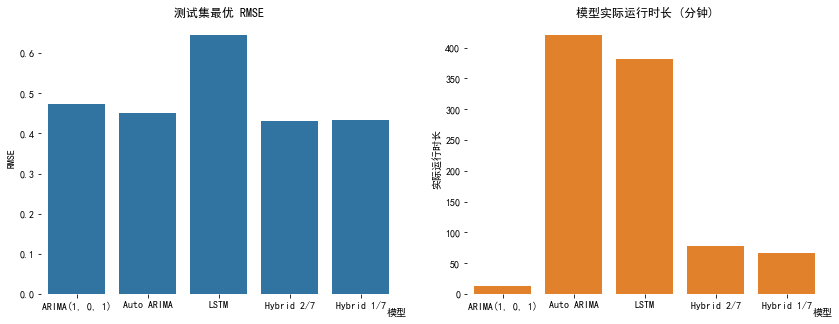

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.despine(bottom = True, left = True)
sns.barplot(ax=axs[0], x=["ARIMA(1, 0, 1)", "Auto ARIMA", "LSTM", "Hybrid 2/7", "Hybrid 1/7"], 
            y=[0.47291, 0.45133, 0.64427, 0.43007, 0.43392], color="tab:blue")
axs[0].set(xlabel="模型", ylabel="RMSE", title="测试集最优 RMSE")
axs[0].xaxis.set_label_coords(1, -0.05)
sns.barplot(ax=axs[1], x=["ARIMA(1, 0, 1)", "Auto ARIMA", "LSTM", "Hybrid 2/7", "Hybrid 1/7"], 
            y=[13, 420, 381, 78, 67], color="tab:orange")
axs[1].set(xlabel="模型", ylabel="实际运行时长", title="模型实际运行时长 (分钟)")
axs[1].xaxis.set_label_coords(1, -0.05)

<p style="line-height:2">
    在本数据集上，混合模型的综合表现最佳。特别是混合模型 7 选 2，在达到最佳测试集 RMSE 的同时，运行效率也相对较高。
</p>

<p style="line-height:2">
    截至我提交最后一次预测结果时 (2022/6/17)，该比赛共有 667 支队伍参加，我的最佳排名是 108，约为前 16.19% 。下面是参赛队伍数以及我的排名截图。
</p>

<img src="./Figures/teams.png" width=800 />
<img src="./Figures/rank.png" width=800 />

<br></br>
**It's fun to work on the project. :-)**
<br></br>
**END**